# Sprint 2 - Classificação Binária de Doenças em Folhas de Café

Este notebook implementa um modelo de classificação binária para detectar se uma folha de café é:
- **Saudável (Healthy)**: Classe 0
- **Não Saudável (Doente)**: Classe 1 (todas as doenças combinadas)

## Características do Modelo:
- **Classificação Binária**: Simplifica o problema para aumentar a acurácia
- **Data Augmentation Avançada**: Técnicas de aumento de dados
- **Arquiteturas Customizadas**: CNNs otimizadas para classificação binária
- **Learning Rate Scheduling**: Ajuste dinâmico da taxa de aprendizado
- **Early Stopping**: Prevenção de overfitting
- **Métricas Detalhadas**: Precision, Recall, F1-Score para cada classe
- **Visualização de Steps**: Progresso detalhado durante o treinamento

## Classes Originais Convertidas:
- **Healthy** → Saudável (0)
- **Cerscospora** → Não Saudável (1)
- **Leaf rust** → Não Saudável (1)
- **Miner** → Não Saudável (1)
- **Phoma** → Não Saudável (1)

## 1. Download dos Datasets

In [1]:
# Download dos Datasets do Kaggle
import kagglehub

print("📥 Baixando datasets de doenças em folhas de café...")

# Download dos datasets
noamaanabdulazeem_jmuben_coffee_dataset_path = kagglehub.dataset_download('noamaanabdulazeem/jmuben-coffee-dataset')
gauravduttakiit_coffee_leaf_diseases_path = kagglehub.dataset_download('gauravduttakiit/coffee-leaf-diseases')
biniyamyoseph_ethiopian_coffee_leaf_disease_path = kagglehub.dataset_download('biniyamyoseph/ethiopian-coffee-leaf-disease')
mohammedzwaughfa_coffee_leaf_disease_dataset_path = kagglehub.dataset_download('mohammedzwaughfa/coffee-leaf-disease-dataset')

print('✅ Download dos datasets concluído!')
print(f"Dataset 1: {noamaanabdulazeem_jmuben_coffee_dataset_path}")
print(f"Dataset 2: {gauravduttakiit_coffee_leaf_diseases_path}")
print(f"Dataset 3: {biniyamyoseph_ethiopian_coffee_leaf_disease_path}")
print(f"Dataset 4: {mohammedzwaughfa_coffee_leaf_disease_dataset_path}")

📥 Baixando datasets de doenças em folhas de café...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 773M/773M [00:27<00:00, 29.7MB/s]

Extracting files...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 181M/181M [00:07<00:00, 24.4MB/s]

Extracting files...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1.91G/1.91G [01:07<00:00, 30.2MB/s]


Extracting files...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 288M/288M [00:11<00:00, 27.4MB/s]

Extracting files...


✅ Download dos datasets concluído!
Dataset 1: /home/t21-g112/.cache/kagglehub/datasets/noamaanabdulazeem/jmuben-coffee-dataset/versions/2
Dataset 2: /home/t21-g112/.cache/kagglehub/datasets/gauravduttakiit/coffee-leaf-diseases/versions/1
Dataset 3: /home/t21-g112/.cache/kagglehub/datasets/biniyamyoseph/ethiopian-coffee-leaf-disease/versions/1
Dataset 4: /home/t21-g112/.cache/kagglehub/datasets/mohammedzwaughfa/coffee-leaf-disease-dataset/versions/1


## 2. Importação de Bibliotecas

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, StepLR
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from pathlib import Path
import time
import json
from collections import defaultdict, Counter
import warnings
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda
GPU: NVIDIA RTX 4000 Ada Generation
CUDA Version: 12.8
Memory: 19.5 GB


## 3. Configuração do Modelo

In [3]:
# Configuration for Binary Classification
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patience': 10,  # For early stopping
    'min_delta': 0.001,  # Minimum change to qualify as improvement
    'subset_fraction': 0.8,  # Use 80% of data
    
    # Data paths
    'save_dir': './modulo_final/sprint_2/modelos',  # For saving models
    
    # Class information - BINARY CLASSIFICATION
    'class_names': ['Saudável', 'Não Saudável'],
    'num_classes': 2,
    
    # Model configurations
    'models_to_train': ['BinaryCNN_Light', 'BinaryCNN_Deep', 'BinaryCNN_Efficient'],
    
    # Training parameters
    'use_mixed_precision': True,
    'gradient_clip_norm': 1.0,
    'scheduler_type': 'cosine',
    
    # Data augmentation
    'use_advanced_augmentation': True,
    'mixup_alpha': 0.2,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1
}

# Create save directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

print("Configuration loaded successfully!")
print(f"Number of classes: {CONFIG['num_classes']}")
print(f"Classes: {CONFIG['class_names']}")
print(f"Models to train: {CONFIG['models_to_train']}")
print(f"Save directory: {CONFIG['save_dir']}")

Configuration loaded successfully!
Number of classes: 2
Classes: ['Saudável', 'Não Saudável']
Models to train: ['BinaryCNN_Light', 'BinaryCNN_Deep', 'BinaryCNN_Efficient']
Save directory: ./modulo_final/sprint_2/modelos


## 4. Dataset Customizado para Classificação Binária

In [4]:
class BinaryDataset(Dataset):
    """Dataset wrapper that converts multi-class to binary classification"""
    def __init__(self, original_dataset, healthy_class_idx=1):
        """
        Args:
            original_dataset: The original multi-class dataset
            healthy_class_idx: Index of the 'Healthy' class in original dataset
        """
        self.dataset = original_dataset
        self.healthy_class_idx = healthy_class_idx
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Convert to binary: 0 = Healthy, 1 = Not Healthy
        binary_label = 0 if label == self.healthy_class_idx else 1
        return image, binary_label

print("Binary dataset class created successfully!")

Binary dataset class created successfully!


## 5. Data Augmentation

In [5]:
# Advanced Data Augmentation
class AdvancedTransforms:
    """Advanced data augmentation techniques for better model generalization"""
    
    @staticmethod
    def get_train_transforms(img_size=224):
        """Get training transforms with advanced augmentation"""
        return transforms.Compose([
            transforms.Resize((img_size + 32, img_size + 32)),
            transforms.RandomCrop(img_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3))
        ])
    
    @staticmethod
    def get_val_transforms(img_size=224):
        """Get validation transforms (minimal augmentation)"""
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# Mixup and CutMix implementations
def mixup_data(x, y, alpha=1.0):
    """Apply mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    return bbx1, bby1, bbx2, bby2

print("Advanced data augmentation functions loaded successfully!")

Advanced data augmentation functions loaded successfully!


## 6. Arquiteturas de CNN para Classificação Binária

In [6]:
# Binary CNN Architectures
class BinaryCNN_Light(nn.Module):
    """Lightweight Binary CNN - Fast and efficient"""
    def __init__(self):
        super(BinaryCNN_Light, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Binary classification
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class BinaryCNN_Deep(nn.Module):
    """Deeper Binary CNN with residual connections"""
    def __init__(self):
        super(BinaryCNN_Deep, self).__init__()
        
        # Use ResNet-like structure
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Binary classification
        )
    
    def _make_layer(self, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(inplanes, planes, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class BasicBlock(nn.Module):
    """Basic residual block"""
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BinaryCNN_Efficient(nn.Module):
    """Efficient Binary CNN - Balanced speed and accuracy"""
    def __init__(self):
        super(BinaryCNN_Efficient, self).__init__()
        
        # Depthwise separable convolutions for efficiency
        self.features = nn.Sequential(
            # Stem
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Depthwise separable blocks
            self._depthwise_separable(32, 64, stride=1),
            self._depthwise_separable(64, 128, stride=2),
            self._depthwise_separable(128, 256, stride=2),
            self._depthwise_separable(256, 512, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Binary classification
        )
    
    def _depthwise_separable(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            # Depthwise
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, 
                     padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            # Pointwise
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

print("Binary CNN architectures loaded successfully!")

Binary CNN architectures loaded successfully!


## 7. Carregamento e Preparação dos Dados

In [7]:
# Dataset paths
DATASET_PATHS = [
    os.path.join(mohammedzwaughfa_coffee_leaf_disease_dataset_path, "dataset/test"),
    os.path.join(gauravduttakiit_coffee_leaf_diseases_path, "train"),
    os.path.join(gauravduttakiit_coffee_leaf_diseases_path, "test"),
    os.path.join(biniyamyoseph_ethiopian_coffee_leaf_disease_path, "ethiopian cofee leaf dataset/train aug"),
    os.path.join(biniyamyoseph_ethiopian_coffee_leaf_disease_path, "ethiopian cofee leaf dataset/test"),
    os.path.join(noamaanabdulazeem_jmuben_coffee_dataset_path, "JMuBEN"),
]

print("🔍 Loading and preparing datasets for binary classification...")

# Load datasets with transforms
train_transform = AdvancedTransforms.get_train_transforms(CONFIG['img_size'])
val_transform = AdvancedTransforms.get_val_transforms(CONFIG['img_size'])

def load_datasets(paths, transform):
    """Load all datasets and combine them"""
    datasets_list = []
    for path in paths:
        if os.path.exists(path):
            ds = datasets.ImageFolder(path, transform=transform)
            datasets_list.append(ds)
            print(f"  Loaded: {path.split('/')[-1]} - {len(ds)} samples")
    return ConcatDataset(datasets_list) if datasets_list else None

# Load combined dataset
combined_dataset = load_datasets(DATASET_PATHS, train_transform)

if combined_dataset is None:
    raise ValueError("No datasets were loaded. Please check the dataset paths.")

# Find the index of 'Healthy' class in the original dataset
# Assuming the first dataset has the class structure
sample_dataset = datasets.ImageFolder(DATASET_PATHS[0], transform=train_transform)
original_classes = sample_dataset.classes
print(f"\nOriginal classes: {original_classes}")

# Find healthy class index (usually 'Healthy' or similar)
healthy_idx = None
for idx, class_name in enumerate(original_classes):
    if 'healthy' in class_name.lower():
        healthy_idx = idx
        print(f"Found 'Healthy' class at index {healthy_idx}")
        break

if healthy_idx is None:
    print("Warning: 'Healthy' class not found. Using index 1 as default.")
    healthy_idx = 1

# Convert to binary dataset
binary_dataset = BinaryDataset(combined_dataset, healthy_class_idx=healthy_idx)

# Use subset for faster training
subset_size = int(len(binary_dataset) * CONFIG['subset_fraction'])
binary_dataset, _ = random_split(binary_dataset, [subset_size, len(binary_dataset) - subset_size])

# Split into train and validation
train_size = int(0.7 * len(binary_dataset))
val_size = len(binary_dataset) - train_size

train_data, val_data = random_split(binary_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

print(f"\n✅ Dataset preparation completed!")
print(f"Total samples: {len(binary_dataset)}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"\nBinary classes: {CONFIG['class_names']}")

🔍 Loading and preparing datasets for binary classification...
  Loaded: test - 400 samples
  Loaded: train - 1264 samples
  Loaded: test - 400 samples
  Loaded: train aug - 10800 samples
  Loaded: test - 1200 samples
  Loaded: JMuBEN - 58549 samples

Original classes: ['Healthy', 'Miner', 'Phoma', 'Rust']
Found 'Healthy' class at index 0

✅ Dataset preparation completed!
Total samples: 58090
Training samples: 40663
Validation samples: 17427
Training batches: 1271
Validation batches: 545

Binary classes: ['Saudável', 'Não Saudável']


## 8. Funções de Treinamento e Avaliação

In [8]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}

class MetricsTracker:
    """Track training metrics"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_precisions = []
        self.val_precisions = []
        self.train_recalls = []
        self.val_recalls = []
        self.train_f1s = []
        self.val_f1s = []
        self.learning_rates = []
        self.epochs = []
    
    def update(self, epoch, train_loss, val_loss, train_metrics, val_metrics, lr):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_metrics['accuracy'])
        self.val_accuracies.append(val_metrics['accuracy'])
        self.train_precisions.append(train_metrics['precision'])
        self.val_precisions.append(val_metrics['precision'])
        self.train_recalls.append(train_metrics['recall'])
        self.val_recalls.append(val_metrics['recall'])
        self.train_f1s.append(train_metrics['f1'])
        self.val_f1s.append(val_metrics['f1'])
        self.learning_rates.append(lr)
    
    def get_best_epoch(self):
        best_idx = np.argmax(self.val_accuracies)
        return self.epochs[best_idx], self.val_accuracies[best_idx]

def calculate_metrics(all_preds, all_targets):
    """Calculate binary classification metrics"""
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)
    
    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100
    }

def train_and_evaluate_model(model, model_name, train_loader, val_loader, config):
    """Train and evaluate binary classification model with detailed progress"""
    print(f"\n{'='*80}")
    print(f"🔧 Training: {model_name}")
    print(f"{'='*80}")
    
    metrics = MetricsTracker()
    early_stopping = EarlyStopping(patience=config['patience'], min_delta=config['min_delta'])
    
    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    
    if config['scheduler_type'] == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'])
    elif config['scheduler_type'] == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    else:
        scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
    
    scaler = torch.cuda.amp.GradScaler() if config['use_mixed_precision'] and torch.cuda.is_available() else None
    
    model.to(device)
    
    print(f"\n📊 Model Configuration:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Total parameters: {total_params:,}")
    print(f"  Epochs: {config['num_epochs']}")
    print(f"  Learning rate: {config['learning_rate']}")
    print(f"  Batch size: {config['batch_size']}")
    print(f"  Scheduler: {config['scheduler_type']}")
    print(f"  Mixed precision: {config['use_mixed_precision']}")
    print(f"\n🚀 Starting training...\n")
    
    start_time = time.time()
    
    for epoch in range(config['num_epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_targets = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]")
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # Apply augmentation
            if config['use_advanced_augmentation'] and np.random.random() < 0.5:
                if np.random.random() < 0.5:
                    data, target_a, target_b, lam = mixup_data(data, target, config['mixup_alpha'])
                    if scaler:
                        with torch.cuda.amp.autocast():
                            output = model(data)
                            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                    else:
                        output = model(data)
                        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                else:
                    data, target_a, target_b, lam = cutmix_data(data, target, config['cutmix_alpha'])
                    if scaler:
                        with torch.cuda.amp.autocast():
                            output = model(data)
                            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                    else:
                        output = model(data)
                        loss = mixup_criterion(.venv0criterion, output, target_a, target_b, lam)
            else:
                if scaler:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        loss = criterion(output, target)
                else:
                    output = model(data)
                    loss = criterion(output, target)
            
            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip_norm'])
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip_norm'])
                optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_targets.extend(target.cpu().numpy())
            
            # Update progress bar
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_targets = []
        
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]  ")
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_targets.extend(target.cpu().numpy())
                
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_metrics = calculate_metrics(all_train_preds, all_train_targets)
        val_metrics = calculate_metrics(all_val_preds, all_val_targets)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        metrics.update(epoch, train_loss, val_loss, train_metrics, val_metrics, current_lr)
        
        # Print epoch summary
        print(f"\n{'─'*80}")
        print(f"Epoch {epoch+1}/{config['num_epochs']} Summary:")
        print(f"{'─'*80}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_metrics['accuracy']:.2f}% | Val Acc: {val_metrics['accuracy']:.2f}%")
        print(f"Train Prec: {train_metrics['precision']:.2f}% | Val Prec: {val_metrics['precision']:.2f}%")
        print(f"Train Recall: {train_metrics['recall']:.2f}% | Val Recall: {val_metrics['recall']:.2f}%")
        print(f"Train F1: {train_metrics['f1']:.2f}% | Val F1: {val_metrics['f1']:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"{'─'*80}\n")
        
        # Learning rate scheduling
        if config['scheduler_type'] == 'plateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Early stopping
        if early_stopping(val_loss, model):
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    best_epoch, best_val_acc = metrics.get_best_epoch()
    
    print(f"\n{'='*80}")
    print(f"✅ Training Completed!")
    print(f"{'='*80}")
    print(f"Total training time: {training_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")
    print(f"{'='*80}\n")
    
    return model, metrics

print("Training and evaluation functions loaded successfully!")

Training and evaluation functions loaded successfully!


## 9. Funções de Visualização

In [9]:
def plot_training_curves(metrics, model_name, save_path=None):
    """Plot comprehensive training curves for binary classification"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name} - Binary Classification Training Progress', fontsize=16, fontweight='bold')
    
    # Loss curves
    axes[0, 0].plot(metrics.epochs, metrics.train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(metrics.epochs, metrics.val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(metrics.epochs, metrics.train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(metrics.epochs, metrics.val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy Curves')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision curves
    axes[0, 2].plot(metrics.epochs, metrics.train_precisions, 'b-', label='Training Precision', linewidth=2)
    axes[0, 2].plot(metrics.epochs, metrics.val_precisions, 'r-', label='Validation Precision', linewidth=2)
    axes[0, 2].set_title('Precision Curves')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision (%)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Recall curves
    axes[1, 0].plot(metrics.epochs, metrics.train_recalls, 'b-', label='Training Recall', linewidth=2)
    axes[1, 0].plot(metrics.epochs, metrics.val_recalls, 'r-', label='Validation Recall', linewidth=2)
    axes[1, 0].set_title('Recall Curves')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1-Score curves
    axes[1, 1].plot(metrics.epochs, metrics.train_f1s, 'b-', label='Training F1-Score', linewidth=2)
    axes[1, 1].plot(metrics.epochs, metrics.val_f1s, 'r-', label='Validation F1-Score', linewidth=2)
    axes[1, 1].set_title('F1-Score Curves')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1-Score (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning rate curve
    axes[1, 2].plot(metrics.epochs, metrics.learning_rates, 'g-', linewidth=2)
    axes[1, 2].set_title('Learning Rate Schedule')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Learning Rate')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Training curves saved to {save_path}")
    
    plt.show()

def plot_confusion_matrix(model, data_loader, class_names, model_name, save_path=None):
    """Plot confusion matrix for binary classification"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc="Calculating confusion matrix"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'{model_name} - Binary Classification Performance', fontsize=16, fontweight='bold')
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Confusion matrix saved to {save_path}")
    
    plt.show()
    
    # Print classification report
    print(f"\n{'='*80}")
    print(f"{model_name} - Classification Report")
    print(f"{'='*80}")
    print(classification_report(all_targets, all_preds, target_names=class_names))
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"{'='*80}\n")

def plot_model_comparison(all_metrics, save_path=None):
    """Plot comparison between different models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Sprint 2 - Binary Classification Model Comparison', fontsize=16, fontweight='bold')
    
    model_names = list(all_metrics.keys())
    
    # Best validation accuracy
    best_accuracies = [np.max(metrics.val_accuracies) for metrics in all_metrics.values()]
    bars = axes[0, 0].bar(model_names, best_accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 0].set_title('Best Validation Accuracy')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_ylim(0, 100)
    for bar, acc in zip(bars, best_accuracies):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Best F1-Score
    best_f1s = [np.max(metrics.val_f1s) for metrics in all_metrics.values()]
    bars = axes[0, 1].bar(model_names, best_f1s, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 1].set_title('Best Validation F1-Score')
    axes[0, 1].set_ylabel('F1-Score (%)')
    axes[0, 1].set_ylim(0, 100)
    for bar, f1 in zip(bars, best_f1s):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{f1:.2f}%', ha='center', va='bottom', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Accuracy over time
    for model_name, metrics in all_metrics.items():
        axes[1, 0].plot(metrics.epochs, metrics.val_accuracies, label=model_name, linewidth=2)
    axes[1, 0].set_title('Validation Accuracy Over Time')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss over time
    for model_name, metrics in all_metrics.items():
        axes[1, 1].plot(metrics.epochs, metrics.val_losses, label=model_name, linewidth=2)
    axes[1, 1].set_title('Validation Loss Over Time')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Model comparison saved to {save_path}")
    
    plt.show()

print("Visualization functions loaded successfully!")

Visualization functions loaded successfully!


## 10. Pipeline de Treinamento


🚀 Starting Sprint 2 Binary Classification Training Pipeline

📊 Model Information:
────────────────────────────────────────────────────────────────────────────────
BinaryCNN_Light:
  Total parameters: 422,530
  Trainable parameters: 422,530
BinaryCNN_Deep:
  Total parameters: 11,242,498
  Trainable parameters: 11,242,498
BinaryCNN_Efficient:
  Total parameters: 183,266
  Trainable parameters: 183,266
────────────────────────────────────────────────────────────────────────────────


🔧 Training: BinaryCNN_Light

📊 Model Configuration:
  Total parameters: 422,530
  Epochs: 50
  Learning rate: 0.001
  Batch size: 32
  Scheduler: cosine
  Mixed precision: True

🚀 Starting training...



Epoch 1/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.77it/s, loss=0.2649]



────────────────────────────────────────────────────────────────────────────────
Epoch 1/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.4265 | Val Loss: 0.3793
Train Acc: 84.97% | Val Acc: 88.32%
Train Prec: 86.90% | Val Prec: 90.66%
Train Recall: 96.73% | Val Recall: 96.16%
Train F1: 91.55% | Val F1: 93.32%
Learning Rate: 0.001000
────────────────────────────────────────────────────────────────────────────────



Epoch 2/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.26it/s, loss=0.2758]



────────────────────────────────────────────────────────────────────────────────
Epoch 2/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3994 | Val Loss: 0.3324
Train Acc: 86.63% | Val Acc: 91.58%
Train Prec: 88.97% | Val Prec: 94.47%
Train Recall: 96.02% | Val Recall: 95.69%
Train F1: 92.36% | Val F1: 95.08%
Learning Rate: 0.000999
────────────────────────────────────────────────────────────────────────────────



Epoch 3/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.49it/s, loss=0.2539]



────────────────────────────────────────────────────────────────────────────────
Epoch 3/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3808 | Val Loss: 0.3258
Train Acc: 87.59% | Val Acc: 92.91%
Train Prec: 90.14% | Val Prec: 95.20%
Train Recall: 95.73% | Val Recall: 96.52%
Train F1: 92.85% | Val F1: 95.86%
Learning Rate: 0.000996
────────────────────────────────────────────────────────────────────────────────



Epoch 4/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.87it/s, loss=0.2213]



────────────────────────────────────────────────────────────────────────────────
Epoch 4/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3680 | Val Loss: 0.3051
Train Acc: 88.39% | Val Acc: 94.00%
Train Prec: 90.86% | Val Prec: 95.07%
Train Recall: 95.84% | Val Recall: 98.01%
Train F1: 93.28% | Val F1: 96.52%
Learning Rate: 0.000991
────────────────────────────────────────────────────────────────────────────────



Epoch 5/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.05it/s, loss=0.2248]



────────────────────────────────────────────────────────────────────────────────
Epoch 5/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3596 | Val Loss: 0.2936
Train Acc: 89.16% | Val Acc: 95.04%
Train Prec: 91.46% | Val Prec: 95.85%
Train Recall: 96.10% | Val Recall: 98.43%
Train F1: 93.72% | Val F1: 97.12%
Learning Rate: 0.000984
────────────────────────────────────────────────────────────────────────────────



Epoch 6/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.68it/s, loss=0.2262]



────────────────────────────────────────────────────────────────────────────────
Epoch 6/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3538 | Val Loss: 0.2926
Train Acc: 89.56% | Val Acc: 94.58%
Train Prec: 91.76% | Val Prec: 94.93%
Train Recall: 96.23% | Val Recall: 98.89%
Train F1: 93.94% | Val F1: 96.87%
Learning Rate: 0.000976
────────────────────────────────────────────────────────────────────────────────



Epoch 7/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.81it/s, loss=0.2233]



────────────────────────────────────────────────────────────────────────────────
Epoch 7/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3426 | Val Loss: 0.2790
Train Acc: 90.18% | Val Acc: 95.57%
Train Prec: 92.33% | Val Prec: 95.95%
Train Recall: 96.32% | Val Recall: 98.96%
Train F1: 94.29% | Val F1: 97.43%
Learning Rate: 0.000965
────────────────────────────────────────────────────────────────────────────────



Epoch 8/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.85it/s, loss=0.2221]



────────────────────────────────────────────────────────────────────────────────
Epoch 8/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3422 | Val Loss: 0.2774
Train Acc: 90.38% | Val Acc: 95.75%
Train Prec: 92.32% | Val Prec: 96.20%
Train Recall: 96.60% | Val Recall: 98.90%
Train F1: 94.41% | Val F1: 97.53%
Learning Rate: 0.000952
────────────────────────────────────────────────────────────────────────────────



Epoch 9/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.30it/s, loss=0.2233]



────────────────────────────────────────────────────────────────────────────────
Epoch 9/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3362 | Val Loss: 0.2747
Train Acc: 90.18% | Val Acc: 95.95%
Train Prec: 92.33% | Val Prec: 96.76%
Train Recall: 96.33% | Val Recall: 98.53%
Train F1: 94.29% | Val F1: 97.64%
Learning Rate: 0.000938
────────────────────────────────────────────────────────────────────────────────



Epoch 10/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.95it/s, loss=0.2130]



────────────────────────────────────────────────────────────────────────────────
Epoch 10/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3314 | Val Loss: 0.2680
Train Acc: 91.04% | Val Acc: 96.56%
Train Prec: 92.90% | Val Prec: 97.19%
Train Recall: 96.75% | Val Recall: 98.81%
Train F1: 94.79% | Val F1: 97.99%
Learning Rate: 0.000922
────────────────────────────────────────────────────────────────────────────────



Epoch 11/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.90it/s, loss=0.2131]



────────────────────────────────────────────────────────────────────────────────
Epoch 11/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3269 | Val Loss: 0.2657
Train Acc: 90.89% | Val Acc: 96.34%
Train Prec: 92.81% | Val Prec: 97.16%
Train Recall: 96.65% | Val Recall: 98.57%
Train F1: 94.69% | Val F1: 97.86%
Learning Rate: 0.000905
────────────────────────────────────────────────────────────────────────────────



Epoch 12/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.59it/s, loss=0.2053]



────────────────────────────────────────────────────────────────────────────────
Epoch 12/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3235 | Val Loss: 0.2701
Train Acc: 91.23% | Val Acc: 96.13%
Train Prec: 93.08% | Val Prec: 96.75%
Train Recall: 96.77% | Val Recall: 98.76%
Train F1: 94.89% | Val F1: 97.75%
Learning Rate: 0.000885
────────────────────────────────────────────────────────────────────────────────



Epoch 13/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.79it/s, loss=0.2081]



────────────────────────────────────────────────────────────────────────────────
Epoch 13/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3237 | Val Loss: 0.2527
Train Acc: 91.18% | Val Acc: 97.42%
Train Prec: 93.04% | Val Prec: 97.89%
Train Recall: 96.76% | Val Recall: 99.10%
Train F1: 94.86% | Val F1: 98.49%
Learning Rate: 0.000864
────────────────────────────────────────────────────────────────────────────────



Epoch 14/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.63it/s, loss=0.2094]



────────────────────────────────────────────────────────────────────────────────
Epoch 14/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3158 | Val Loss: 0.2478
Train Acc: 91.07% | Val Acc: 97.51%
Train Prec: 93.14% | Val Prec: 98.32%
Train Recall: 96.49% | Val Recall: 98.76%
Train F1: 94.79% | Val F1: 98.54%
Learning Rate: 0.000842
────────────────────────────────────────────────────────────────────────────────



Epoch 15/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.85it/s, loss=0.2197]



────────────────────────────────────────────────────────────────────────────────
Epoch 15/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3116 | Val Loss: 0.2469
Train Acc: 91.86% | Val Acc: 97.53%
Train Prec: 93.54% | Val Prec: 97.84%
Train Recall: 97.02% | Val Recall: 99.29%
Train F1: 95.25% | Val F1: 98.56%
Learning Rate: 0.000819
────────────────────────────────────────────────────────────────────────────────



Epoch 16/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.26it/s, loss=0.2054]



────────────────────────────────────────────────────────────────────────────────
Epoch 16/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3083 | Val Loss: 0.2489
Train Acc: 91.86% | Val Acc: 97.38%
Train Prec: 93.63% | Val Prec: 97.85%
Train Recall: 96.92% | Val Recall: 99.10%
Train F1: 95.25% | Val F1: 98.47%
Learning Rate: 0.000794
────────────────────────────────────────────────────────────────────────────────



Epoch 17/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.34it/s, loss=0.2041]



────────────────────────────────────────────────────────────────────────────────
Epoch 17/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3075 | Val Loss: 0.2425
Train Acc: 92.16% | Val Acc: 97.94%
Train Prec: 93.90% | Val Prec: 98.24%
Train Recall: 96.98% | Val Recall: 99.35%
Train F1: 95.42% | Val F1: 98.79%
Learning Rate: 0.000768
────────────────────────────────────────────────────────────────────────────────



Epoch 18/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.47it/s, loss=0.2018]



────────────────────────────────────────────────────────────────────────────────
Epoch 18/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3077 | Val Loss: 0.2397
Train Acc: 92.16% | Val Acc: 98.07%
Train Prec: 93.86% | Val Prec: 98.40%
Train Recall: 97.03% | Val Recall: 99.34%
Train F1: 95.42% | Val F1: 98.87%
Learning Rate: 0.000741
────────────────────────────────────────────────────────────────────────────────



Epoch 19/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.05it/s, loss=0.2134]



────────────────────────────────────────────────────────────────────────────────
Epoch 19/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3013 | Val Loss: 0.2442
Train Acc: 92.14% | Val Acc: 97.64%
Train Prec: 93.90% | Val Prec: 97.56%
Train Recall: 96.95% | Val Recall: 99.72%
Train F1: 95.40% | Val F1: 98.63%
Learning Rate: 0.000713
────────────────────────────────────────────────────────────────────────────────



Epoch 20/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.63it/s, loss=0.2053]



────────────────────────────────────────────────────────────────────────────────
Epoch 20/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3023 | Val Loss: 0.2387
Train Acc: 92.24% | Val Acc: 98.08%
Train Prec: 93.90% | Val Prec: 98.43%
Train Recall: 97.08% | Val Recall: 99.33%
Train F1: 95.46% | Val F1: 98.88%
Learning Rate: 0.000684
────────────────────────────────────────────────────────────────────────────────



Epoch 21/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.74it/s, loss=0.2075]



────────────────────────────────────────────────────────────────────────────────
Epoch 21/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2974 | Val Loss: 0.2368
Train Acc: 92.50% | Val Acc: 98.26%
Train Prec: 94.18% | Val Prec: 98.66%
Train Recall: 97.09% | Val Recall: 99.30%
Train F1: 95.61% | Val F1: 98.98%
Learning Rate: 0.000655
────────────────────────────────────────────────────────────────────────────────



Epoch 22/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.46it/s, loss=0.2023]



────────────────────────────────────────────────────────────────────────────────
Epoch 22/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2982 | Val Loss: 0.2355
Train Acc: 92.87% | Val Acc: 98.14%
Train Prec: 94.35% | Val Prec: 98.39%
Train Recall: 97.37% | Val Recall: 99.43%
Train F1: 95.83% | Val F1: 98.91%
Learning Rate: 0.000624
────────────────────────────────────────────────────────────────────────────────



Epoch 23/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.22it/s, loss=0.2029]



────────────────────────────────────────────────────────────────────────────────
Epoch 23/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2956 | Val Loss: 0.2357
Train Acc: 92.46% | Val Acc: 98.20%
Train Prec: 94.12% | Val Prec: 98.25%
Train Recall: 97.11% | Val Recall: 99.66%
Train F1: 95.59% | Val F1: 98.95%
Learning Rate: 0.000594
────────────────────────────────────────────────────────────────────────────────



Epoch 24/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.51it/s, loss=0.2033]



────────────────────────────────────────────────────────────────────────────────
Epoch 24/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2957 | Val Loss: 0.2345
Train Acc: 92.31% | Val Acc: 98.39%
Train Prec: 93.99% | Val Prec: 98.66%
Train Recall: 97.07% | Val Recall: 99.45%
Train F1: 95.51% | Val F1: 99.05%
Learning Rate: 0.000563
────────────────────────────────────────────────────────────────────────────────



Epoch 25/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.02it/s, loss=0.2001]



────────────────────────────────────────────────────────────────────────────────
Epoch 25/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2917 | Val Loss: 0.2400
Train Acc: 92.77% | Val Acc: 97.92%
Train Prec: 94.36% | Val Prec: 97.88%
Train Recall: 97.22% | Val Recall: 99.72%
Train F1: 95.77% | Val F1: 98.79%
Learning Rate: 0.000531
────────────────────────────────────────────────────────────────────────────────



Epoch 26/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.70it/s, loss=0.2041]



────────────────────────────────────────────────────────────────────────────────
Epoch 26/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2888 | Val Loss: 0.2336
Train Acc: 93.11% | Val Acc: 98.46%
Train Prec: 94.67% | Val Prec: 98.57%
Train Recall: 97.29% | Val Recall: 99.63%
Train F1: 95.96% | Val F1: 99.10%
Learning Rate: 0.000500
────────────────────────────────────────────────────────────────────────────────



Epoch 27/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.62it/s, loss=0.2023]



────────────────────────────────────────────────────────────────────────────────
Epoch 27/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2909 | Val Loss: 0.2337
Train Acc: 93.08% | Val Acc: 98.25%
Train Prec: 94.58% | Val Prec: 98.21%
Train Recall: 97.36% | Val Recall: 99.76%
Train F1: 95.95% | Val F1: 98.98%
Learning Rate: 0.000469
────────────────────────────────────────────────────────────────────────────────



Epoch 28/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 25.98it/s, loss=0.2035]



────────────────────────────────────────────────────────────────────────────────
Epoch 28/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2866 | Val Loss: 0.2318
Train Acc: 93.02% | Val Acc: 98.45%
Train Prec: 94.65% | Val Prec: 98.56%
Train Recall: 97.21% | Val Recall: 99.64%
Train F1: 95.91% | Val F1: 99.09%
Learning Rate: 0.000437
────────────────────────────────────────────────────────────────────────────────



Epoch 29/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.82it/s, loss=0.2022]



────────────────────────────────────────────────────────────────────────────────
Epoch 29/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2898 | Val Loss: 0.2330
Train Acc: 93.03% | Val Acc: 98.42%
Train Prec: 94.56% | Val Prec: 98.54%
Train Recall: 97.31% | Val Recall: 99.61%
Train F1: 95.92% | Val F1: 99.07%
Learning Rate: 0.000406
────────────────────────────────────────────────────────────────────────────────



Epoch 30/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.62it/s, loss=0.2034]



────────────────────────────────────────────────────────────────────────────────
Epoch 30/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2852 | Val Loss: 0.2289
Train Acc: 92.91% | Val Acc: 98.64%
Train Prec: 94.51% | Val Prec: 98.77%
Train Recall: 97.22% | Val Recall: 99.64%
Train F1: 95.85% | Val F1: 99.20%
Learning Rate: 0.000376
────────────────────────────────────────────────────────────────────────────────



Epoch 31/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.18it/s, loss=0.2008]



────────────────────────────────────────────────────────────────────────────────
Epoch 31/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2810 | Val Loss: 0.2284
Train Acc: 93.17% | Val Acc: 98.62%
Train Prec: 94.79% | Val Prec: 98.87%
Train Recall: 97.23% | Val Recall: 99.52%
Train F1: 96.00% | Val F1: 99.19%
Learning Rate: 0.000345
────────────────────────────────────────────────────────────────────────────────



Epoch 32/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.88it/s, loss=0.2007]



────────────────────────────────────────────────────────────────────────────────
Epoch 32/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2817 | Val Loss: 0.2283
Train Acc: 93.60% | Val Acc: 98.57%
Train Prec: 94.94% | Val Prec: 98.99%
Train Recall: 97.60% | Val Recall: 99.32%
Train F1: 96.25% | Val F1: 99.16%
Learning Rate: 0.000316
────────────────────────────────────────────────────────────────────────────────



Epoch 33/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.69it/s, loss=0.2012]



────────────────────────────────────────────────────────────────────────────────
Epoch 33/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2860 | Val Loss: 0.2282
Train Acc: 92.95% | Val Acc: 98.63%
Train Prec: 94.58% | Val Prec: 98.85%
Train Recall: 97.18% | Val Recall: 99.55%
Train F1: 95.87% | Val F1: 99.20%
Learning Rate: 0.000287
────────────────────────────────────────────────────────────────────────────────



Epoch 34/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.87it/s, loss=0.2012]



────────────────────────────────────────────────────────────────────────────────
Epoch 34/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2795 | Val Loss: 0.2238
Train Acc: 93.34% | Val Acc: 98.79%
Train Prec: 94.91% | Val Prec: 98.92%
Train Recall: 97.30% | Val Recall: 99.67%
Train F1: 96.09% | Val F1: 99.29%
Learning Rate: 0.000259
────────────────────────────────────────────────────────────────────────────────



Epoch 35/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.75it/s, loss=0.2022]



────────────────────────────────────────────────────────────────────────────────
Epoch 35/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2779 | Val Loss: 0.2251
Train Acc: 93.55% | Val Acc: 98.71%
Train Prec: 95.00% | Val Prec: 98.82%
Train Recall: 97.47% | Val Recall: 99.67%
Train F1: 96.22% | Val F1: 99.24%
Learning Rate: 0.000232
────────────────────────────────────────────────────────────────────────────────



Epoch 36/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.89it/s, loss=0.2014]



────────────────────────────────────────────────────────────────────────────────
Epoch 36/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2776 | Val Loss: 0.2258
Train Acc: 93.56% | Val Acc: 98.73%
Train Prec: 95.03% | Val Prec: 98.78%
Train Recall: 97.45% | Val Recall: 99.74%
Train F1: 96.22% | Val F1: 99.26%
Learning Rate: 0.000206
────────────────────────────────────────────────────────────────────────────────



Epoch 37/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.94it/s, loss=0.2041]



────────────────────────────────────────────────────────────────────────────────
Epoch 37/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2774 | Val Loss: 0.2265
Train Acc: 93.46% | Val Acc: 98.74%
Train Prec: 95.00% | Val Prec: 98.97%
Train Recall: 97.36% | Val Recall: 99.55%
Train F1: 96.16% | Val F1: 99.26%
Learning Rate: 0.000181
────────────────────────────────────────────────────────────────────────────────



Epoch 38/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.01it/s, loss=0.2018]



────────────────────────────────────────────────────────────────────────────────
Epoch 38/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2735 | Val Loss: 0.2239
Train Acc: 93.47% | Val Acc: 98.75%
Train Prec: 95.10% | Val Prec: 98.91%
Train Recall: 97.26% | Val Recall: 99.63%
Train F1: 96.16% | Val F1: 99.27%
Learning Rate: 0.000158
────────────────────────────────────────────────────────────────────────────────



Epoch 39/50 [Val]  : 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.94it/s, loss=0.2050]



────────────────────────────────────────────────────────────────────────────────
Epoch 39/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2760 | Val Loss: 0.2227
Train Acc: 93.30% | Val Acc: 98.82%
Train Prec: 94.97% | Val Prec: 98.92%
Train Recall: 97.18% | Val Recall: 99.70%
Train F1: 96.06% | Val F1: 99.31%
Learning Rate: 0.000136
────────────────────────────────────────────────────────────────────────────────



Epoch 40/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.37it/s, loss=0.2003]



────────────────────────────────────────────────────────────────────────────────
Epoch 40/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2788 | Val Loss: 0.2224
Train Acc: 93.74% | Val Acc: 98.79%
Train Prec: 95.11% | Val Prec: 98.86%
Train Recall: 97.59% | Val Recall: 99.73%
Train F1: 96.33% | Val F1: 99.29%
Learning Rate: 0.000115
────────────────────────────────────────────────────────────────────────────────



Epoch 41/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.02it/s, loss=0.2045]



────────────────────────────────────────────────────────────────────────────────
Epoch 41/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2739 | Val Loss: 0.2229
Train Acc: 93.63% | Val Acc: 98.80%
Train Prec: 95.13% | Val Prec: 98.89%
Train Recall: 97.42% | Val Recall: 99.71%
Train F1: 96.26% | Val F1: 99.30%
Learning Rate: 0.000095
────────────────────────────────────────────────────────────────────────────────



Epoch 42/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.94it/s, loss=0.2046]



────────────────────────────────────────────────────────────────────────────────
Epoch 42/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2717 | Val Loss: 0.2222
Train Acc: 94.07% | Val Acc: 98.84%
Train Prec: 95.47% | Val Prec: 98.89%
Train Recall: 97.59% | Val Recall: 99.75%
Train F1: 96.51% | Val F1: 99.32%
Learning Rate: 0.000078
────────────────────────────────────────────────────────────────────────────────



Epoch 43/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.51it/s, loss=0.2023]



────────────────────────────────────────────────────────────────────────────────
Epoch 43/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2770 | Val Loss: 0.2222
Train Acc: 92.90% | Val Acc: 98.82%
Train Prec: 94.70% | Val Prec: 98.91%
Train Recall: 96.99% | Val Recall: 99.70%
Train F1: 95.83% | Val F1: 99.31%
Learning Rate: 0.000062
────────────────────────────────────────────────────────────────────────────────



Epoch 44/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.28it/s, loss=0.2013]



────────────────────────────────────────────────────────────────────────────────
Epoch 44/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2749 | Val Loss: 0.2220
Train Acc: 93.85% | Val Acc: 98.88%
Train Prec: 95.30% | Val Prec: 98.97%
Train Recall: 97.50% | Val Recall: 99.72%
Train F1: 96.39% | Val F1: 99.34%
Learning Rate: 0.000048
────────────────────────────────────────────────────────────────────────────────



Epoch 45/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.69it/s, loss=0.2006]



────────────────────────────────────────────────────────────────────────────────
Epoch 45/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2734 | Val Loss: 0.2210
Train Acc: 93.39% | Val Acc: 98.86%
Train Prec: 95.01% | Val Prec: 98.98%
Train Recall: 97.26% | Val Recall: 99.68%
Train F1: 96.12% | Val F1: 99.33%
Learning Rate: 0.000035
────────────────────────────────────────────────────────────────────────────────



Epoch 46/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.66it/s, loss=0.2011]



────────────────────────────────────────────────────────────────────────────────
Epoch 46/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2727 | Val Loss: 0.2217
Train Acc: 93.81% | Val Acc: 98.82%
Train Prec: 95.27% | Val Prec: 98.87%
Train Recall: 97.48% | Val Recall: 99.76%
Train F1: 96.36% | Val F1: 99.31%
Learning Rate: 0.000024
────────────────────────────────────────────────────────────────────────────────



Epoch 47/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.66it/s, loss=0.2106]



────────────────────────────────────────────────────────────────────────────────
Epoch 47/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2720 | Val Loss: 0.2222
Train Acc: 93.74% | Val Acc: 98.78%
Train Prec: 95.23% | Val Prec: 98.91%
Train Recall: 97.44% | Val Recall: 99.67%
Train F1: 96.32% | Val F1: 99.29%
Learning Rate: 0.000016
────────────────────────────────────────────────────────────────────────────────



Epoch 48/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.65it/s, loss=0.2009]



────────────────────────────────────────────────────────────────────────────────
Epoch 48/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2735 | Val Loss: 0.2212
Train Acc: 93.58% | Val Acc: 98.90%
Train Prec: 95.11% | Val Prec: 98.92%
Train Recall: 97.38% | Val Recall: 99.79%
Train F1: 96.23% | Val F1: 99.35%
Learning Rate: 0.000009
────────────────────────────────────────────────────────────────────────────────



Epoch 49/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.40it/s, loss=0.2070]



────────────────────────────────────────────────────────────────────────────────
Epoch 49/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2745 | Val Loss: 0.2228
Train Acc: 93.30% | Val Acc: 98.84%
Train Prec: 94.95% | Val Prec: 98.94%
Train Recall: 97.21% | Val Recall: 99.70%
Train F1: 96.07% | Val F1: 99.32%
Learning Rate: 0.000004
────────────────────────────────────────────────────────────────────────────────



Epoch 50/50 [Val]  : 100%|██████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.40it/s, loss=0.2022]



────────────────────────────────────────────────────────────────────────────────
Epoch 50/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2733 | Val Loss: 0.2206
Train Acc: 94.10% | Val Acc: 98.88%
Train Prec: 95.50% | Val Prec: 98.95%
Train Recall: 97.59% | Val Recall: 99.73%
Train F1: 96.53% | Val F1: 99.34%
Learning Rate: 0.000001
────────────────────────────────────────────────────────────────────────────────


✅ Training Completed!
Total training time: 59.80 minutes
Best validation accuracy: 98.90% at epoch 48

💾 Model saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Light_best.pth

✅ Training curves saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Light_training_curves.png


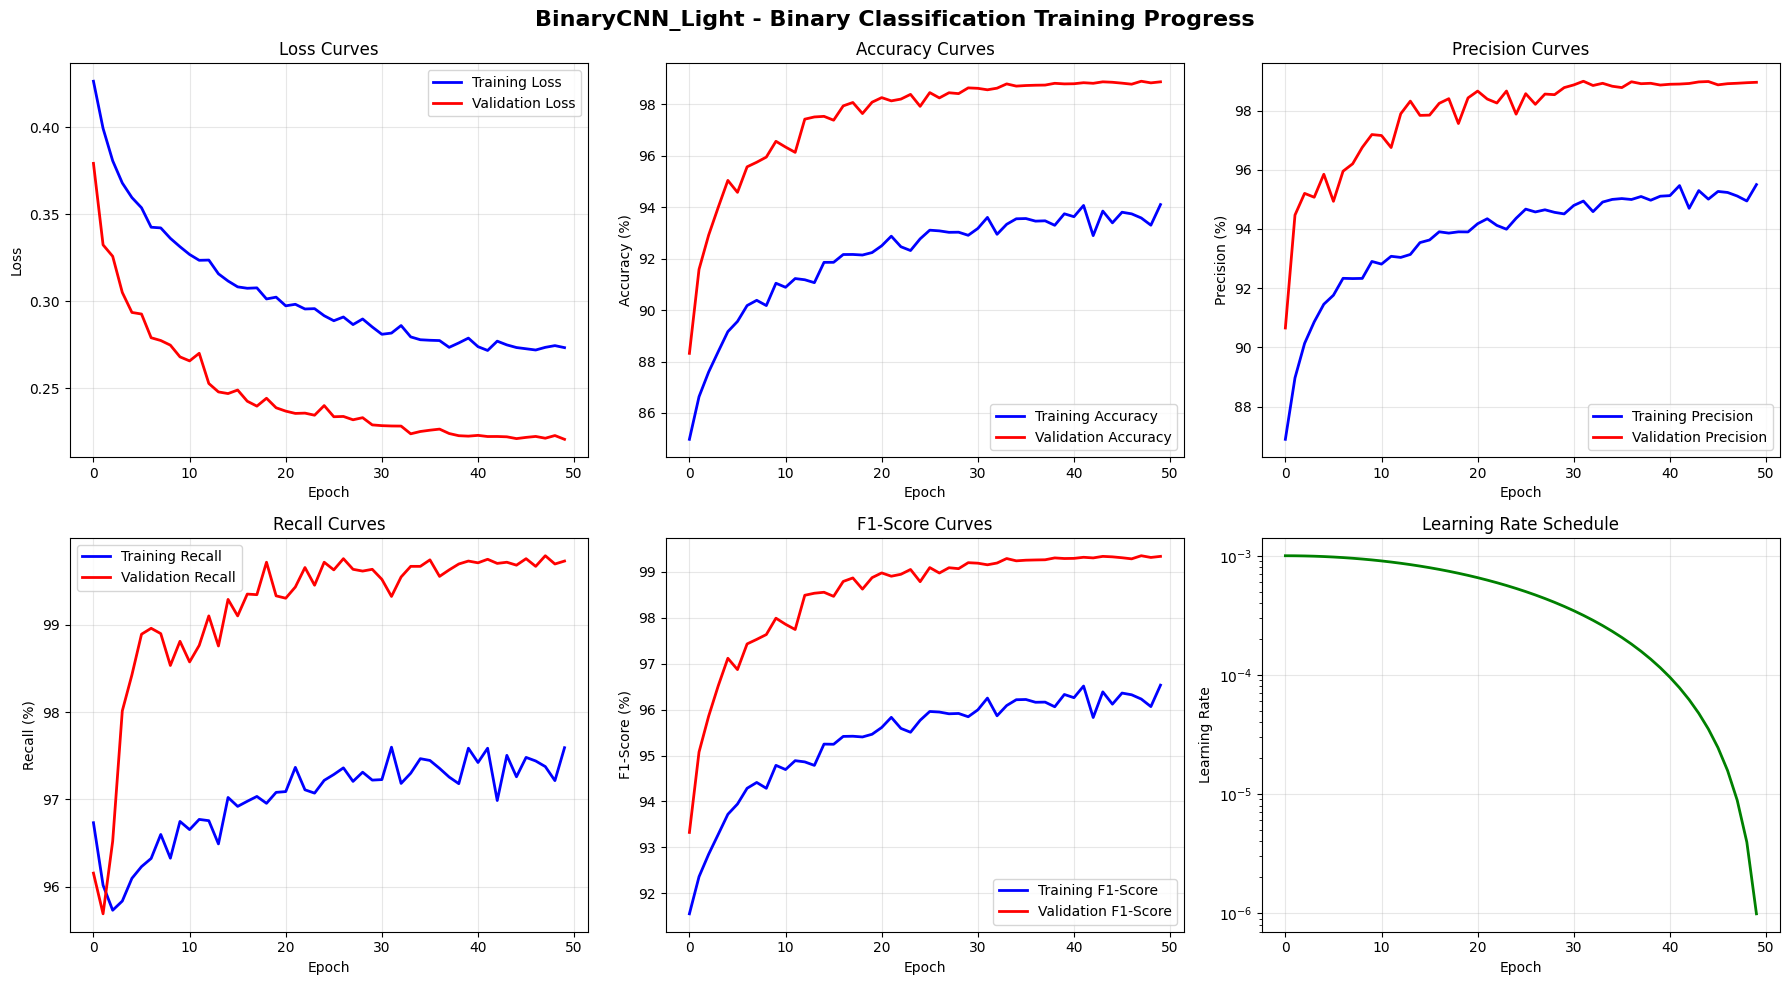

Calculating confusion matrix: 100%|██████████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.81it/s]


✅ Confusion matrix saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Light_confusion_matrix.png


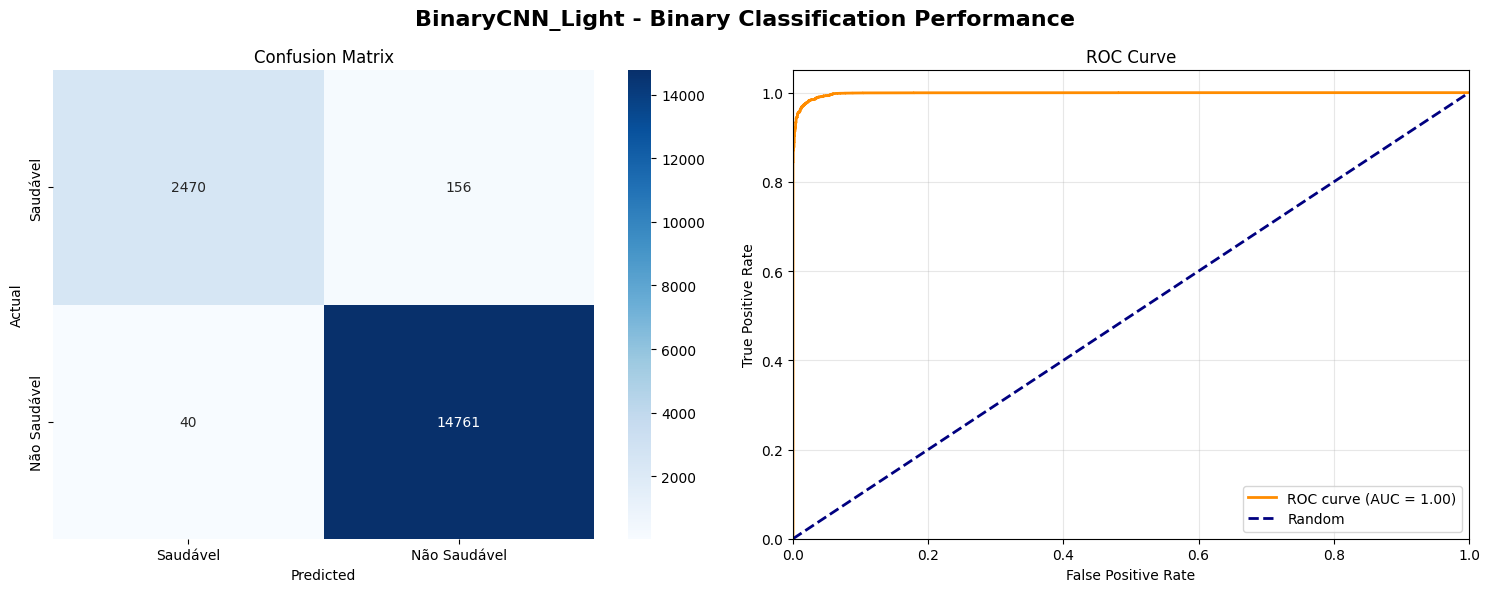


BinaryCNN_Light - Classification Report
              precision    recall  f1-score   support

    Saudável       0.98      0.94      0.96      2626
Não Saudável       0.99      1.00      0.99     14801

    accuracy                           0.99     17427
   macro avg       0.99      0.97      0.98     17427
weighted avg       0.99      0.99      0.99     17427

ROC-AUC Score: 0.9983


🔧 Training: BinaryCNN_Deep

📊 Model Configuration:
  Total parameters: 11,242,498
  Epochs: 50
  Learning rate: 0.001
  Batch size: 32
  Scheduler: cosine
  Mixed precision: True

🚀 Starting training...



Epoch 1/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:20<00:00, 26.24it/s, loss=0.3077]



────────────────────────────────────────────────────────────────────────────────
Epoch 1/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.4353 | Val Loss: 0.4104
Train Acc: 84.78% | Val Acc: 85.76%
Train Prec: 86.47% | Val Prec: 95.00%
Train Recall: 97.12% | Val Recall: 87.85%
Train F1: 91.48% | Val F1: 91.29%
Learning Rate: 0.001000
────────────────────────────────────────────────────────────────────────────────



Epoch 2/50 [Val]  : 100%|███████████████████████████████████████████████████████████| 545/545 [00:21<00:00, 25.93it/s, loss=0.3074]



────────────────────────────────────────────────────────────────────────────────
Epoch 2/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.4017 | Val Loss: 0.3428
Train Acc: 86.33% | Val Acc: 91.17%
Train Prec: 88.87% | Val Prec: 94.74%
Train Recall: 95.75% | Val Recall: 94.87%
Train F1: 92.18% | Val F1: 94.80%
Learning Rate: 0.000999
────────────────────────────────────────────────────────────────────────────────



Epoch 3/50 [Train]: 100%|█████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.64it/s, loss=0.3896]
Epoch 3/50 [Val]  



────────────────────────────────────────────────────────────────────────────────
Epoch 3/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3790 | Val Loss: 0.3261
Train Acc: 87.73% | Val Acc: 92.04%
Train Prec: 90.28% | Val Prec: 93.94%
Train Recall: 95.72% | Val Recall: 96.87%
Train F1: 92.92% | Val F1: 95.38%
Learning Rate: 0.000996
────────────────────────────────────────────────────────────────────────────────



Epoch 4/50 [Train]
Epoch 4/50 [Val]  



────────────────────────────────────────────────────────────────────────────────
Epoch 4/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3642 | Val Loss: 0.2938
Train Acc: 88.88% | Val Acc: 94.51%
Train Prec: 91.19% | Val Prec: 96.52%
Train Recall: 96.08% | Val Recall: 97.03%
Train F1: 93.57% | Val F1: 96.78%
Learning Rate: 0.000991
────────────────────────────────────────────────────────────────────────────────



Epoch 5/50 [Train]
Epoch 5/50 [Val]  



────────────────────────────────────────────────────────────────────────────────
Epoch 5/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3511 | Val Loss: 0.2939
Train Acc: 89.66% | Val Acc: 95.28%
Train Prec: 91.97% | Val Prec: 96.05%
Train Recall: 96.11% | Val Recall: 98.49%
Train F1: 93.99% | Val F1: 97.25%
Learning Rate: 0.000984
────────────────────────────────────────────────────────────────────────────────



Epoch 6/50 [Train]
Epoch 6/50 [Val]  



────────────────────────────────────────────────────────────────────────────────
Epoch 6/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3402 | Val Loss: 0.2700
Train Acc: 89.99% | Val Acc: 96.03%
Train Prec: 92.30% | Val Prec: 96.76%
Train Recall: 96.13% | Val Recall: 98.64%
Train F1: 94.18% | Val F1: 97.69%
Learning Rate: 0.000976
────────────────────────────────────────────────────────────────────────────────



Epoch 7/50 [Train]
Epoch 7/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.86



────────────────────────────────────────────────────────────────────────────────
Epoch 7/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3333 | Val Loss: 0.2699
Train Acc: 90.67% | Val Acc: 96.41%
Train Prec: 92.77% | Val Prec: 97.70%
Train Recall: 96.43% | Val Recall: 98.08%
Train F1: 94.57% | Val F1: 97.89%
Learning Rate: 0.000965
────────────────────────────────────────────────────────────────────────────────



Epoch 8/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26.
Epoch 8/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.47



────────────────────────────────────────────────────────────────────────────────
Epoch 8/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3272 | Val Loss: 0.2650
Train Acc: 90.73% | Val Acc: 96.32%
Train Prec: 92.90% | Val Prec: 96.73%
Train Recall: 96.35% | Val Recall: 99.02%
Train F1: 94.59% | Val F1: 97.86%
Learning Rate: 0.000952
────────────────────────────────────────────────────────────────────────────────



Epoch 9/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26.
Epoch 9/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.97



────────────────────────────────────────────────────────────────────────────────
Epoch 9/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3136 | Val Loss: 0.2645
Train Acc: 91.64% | Val Acc: 96.33%
Train Prec: 93.57% | Val Prec: 98.73%
Train Recall: 96.71% | Val Recall: 96.93%
Train F1: 95.11% | Val F1: 97.82%
Learning Rate: 0.000938
────────────────────────────────────────────────────────────────────────────────



Epoch 10/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 10/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 10/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3146 | Val Loss: 0.2551
Train Acc: 91.55% | Val Acc: 97.01%
Train Prec: 93.48% | Val Prec: 98.41%
Train Recall: 96.70% | Val Recall: 98.06%
Train F1: 95.06% | Val F1: 98.24%
Learning Rate: 0.000922
────────────────────────────────────────────────────────────────────────────────



Epoch 11/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 11/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 11/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3052 | Val Loss: 0.2506
Train Acc: 92.49% | Val Acc: 97.27%
Train Prec: 94.20% | Val Prec: 97.28%
Train Recall: 97.05% | Val Recall: 99.57%
Train F1: 95.60% | Val F1: 98.41%
Learning Rate: 0.000905
────────────────────────────────────────────────────────────────────────────────



Epoch 12/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 12/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.9



────────────────────────────────────────────────────────────────────────────────
Epoch 12/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3038 | Val Loss: 0.2467
Train Acc: 92.19% | Val Acc: 97.56%
Train Prec: 94.01% | Val Prec: 98.33%
Train Recall: 96.89% | Val Recall: 98.80%
Train F1: 95.43% | Val F1: 98.56%
Learning Rate: 0.000885
────────────────────────────────────────────────────────────────────────────────



Epoch 13/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 13/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 13/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3001 | Val Loss: 0.2416
Train Acc: 92.68% | Val Acc: 97.79%
Train Prec: 94.34% | Val Prec: 98.51%
Train Recall: 97.14% | Val Recall: 98.90%
Train F1: 95.72% | Val F1: 98.70%
Learning Rate: 0.000864
────────────────────────────────────────────────────────────────────────────────



Epoch 14/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 14/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.9



────────────────────────────────────────────────────────────────────────────────
Epoch 14/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2967 | Val Loss: 0.2330
Train Acc: 92.55% | Val Acc: 98.09%
Train Prec: 94.25% | Val Prec: 98.22%
Train Recall: 97.06% | Val Recall: 99.55%
Train F1: 95.64% | Val F1: 98.88%
Learning Rate: 0.000842
────────────────────────────────────────────────────────────────────────────────



Epoch 15/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 15/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 15/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2970 | Val Loss: 0.2352
Train Acc: 92.70% | Val Acc: 98.20%
Train Prec: 94.42% | Val Prec: 98.74%
Train Recall: 97.06% | Val Recall: 99.16%
Train F1: 95.72% | Val F1: 98.94%
Learning Rate: 0.000819
────────────────────────────────────────────────────────────────────────────────



Epoch 16/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 16/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 16/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2890 | Val Loss: 0.2339
Train Acc: 93.08% | Val Acc: 98.23%
Train Prec: 94.75% | Val Prec: 98.51%
Train Recall: 97.16% | Val Recall: 99.41%
Train F1: 95.94% | Val F1: 98.96%
Learning Rate: 0.000794
────────────────────────────────────────────────────────────────────────────────



Epoch 17/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 17/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.8



────────────────────────────────────────────────────────────────────────────────
Epoch 17/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2923 | Val Loss: 0.2457
Train Acc: 92.69% | Val Acc: 97.40%
Train Prec: 94.41% | Val Prec: 98.63%
Train Recall: 97.06% | Val Recall: 98.30%
Train F1: 95.72% | Val F1: 98.47%
Learning Rate: 0.000768
────────────────────────────────────────────────────────────────────────────────



Epoch 18/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 18/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 27.2



────────────────────────────────────────────────────────────────────────────────
Epoch 18/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2880 | Val Loss: 0.2374
Train Acc: 93.09% | Val Acc: 98.21%
Train Prec: 94.73% | Val Prec: 98.86%
Train Recall: 97.19% | Val Recall: 99.03%
Train F1: 95.95% | Val F1: 98.95%
Learning Rate: 0.000741
────────────────────────────────────────────────────────────────────────────────



Epoch 19/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 19/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 19/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2850 | Val Loss: 0.2403
Train Acc: 92.53% | Val Acc: 98.19%
Train Prec: 94.45% | Val Prec: 98.72%
Train Recall: 96.81% | Val Recall: 99.15%
Train F1: 95.61% | Val F1: 98.93%
Learning Rate: 0.000713
────────────────────────────────────────────────────────────────────────────────



Epoch 20/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 20/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.8



────────────────────────────────────────────────────────────────────────────────
Epoch 20/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2883 | Val Loss: 0.2300
Train Acc: 93.28% | Val Acc: 98.43%
Train Prec: 94.85% | Val Prec: 98.80%
Train Recall: 97.29% | Val Recall: 99.36%
Train F1: 96.06% | Val F1: 99.08%
Learning Rate: 0.000684
────────────────────────────────────────────────────────────────────────────────



Epoch 21/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 21/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 21/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2813 | Val Loss: 0.2288
Train Acc: 93.47% | Val Acc: 98.49%
Train Prec: 95.04% | Val Prec: 98.62%
Train Recall: 97.31% | Val Recall: 99.62%
Train F1: 96.16% | Val F1: 99.12%
Learning Rate: 0.000655
────────────────────────────────────────────────────────────────────────────────



Epoch 22/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 22/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 22/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2829 | Val Loss: 0.2291
Train Acc: 92.91% | Val Acc: 98.44%
Train Prec: 94.64% | Val Prec: 98.69%
Train Recall: 97.06% | Val Recall: 99.49%
Train F1: 95.84% | Val F1: 99.08%
Learning Rate: 0.000624
────────────────────────────────────────────────────────────────────────────────



Epoch 23/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 23/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 23/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2767 | Val Loss: 0.2324
Train Acc: 93.38% | Val Acc: 98.43%
Train Prec: 95.08% | Val Prec: 98.83%
Train Recall: 97.16% | Val Recall: 99.32%
Train F1: 96.11% | Val F1: 99.08%
Learning Rate: 0.000594
────────────────────────────────────────────────────────────────────────────────



Epoch 24/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 24/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 27.1



────────────────────────────────────────────────────────────────────────────────
Epoch 24/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2781 | Val Loss: 0.2274
Train Acc: 93.28% | Val Acc: 98.32%
Train Prec: 94.95% | Val Prec: 98.85%
Train Recall: 97.18% | Val Recall: 99.18%
Train F1: 96.05% | Val F1: 99.01%
Learning Rate: 0.000563
────────────────────────────────────────────────────────────────────────────────



Epoch 25/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 25/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 27.0



────────────────────────────────────────────────────────────────────────────────
Epoch 25/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2773 | Val Loss: 0.2266
Train Acc: 93.65% | Val Acc: 98.50%
Train Prec: 95.23% | Val Prec: 98.63%
Train Recall: 97.33% | Val Recall: 99.61%
Train F1: 96.27% | Val F1: 99.12%
Learning Rate: 0.000531
────────────────────────────────────────────────────────────────────────────────



Epoch 26/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 26/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 27.1



────────────────────────────────────────────────────────────────────────────────
Epoch 26/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2756 | Val Loss: 0.2228
Train Acc: 93.25% | Val Acc: 98.62%
Train Prec: 95.01% | Val Prec: 99.08%
Train Recall: 97.09% | Val Recall: 99.30%
Train F1: 96.04% | Val F1: 99.19%
Learning Rate: 0.000500
────────────────────────────────────────────────────────────────────────────────



Epoch 27/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 25
Epoch 27/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 27/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2714 | Val Loss: 0.2208
Train Acc: 93.76% | Val Acc: 98.83%
Train Prec: 95.38% | Val Prec: 99.07%
Train Recall: 97.31% | Val Recall: 99.55%
Train F1: 96.33% | Val F1: 99.31%
Learning Rate: 0.000469
────────────────────────────────────────────────────────────────────────────────



Epoch 28/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 28/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 28/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2754 | Val Loss: 0.2292
Train Acc: 93.32% | Val Acc: 98.15%
Train Prec: 95.09% | Val Prec: 98.82%
Train Recall: 97.07% | Val Recall: 99.00%
Train F1: 96.07% | Val F1: 98.91%
Learning Rate: 0.000437
────────────────────────────────────────────────────────────────────────────────



Epoch 29/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 29/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.4



────────────────────────────────────────────────────────────────────────────────
Epoch 29/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2704 | Val Loss: 0.2205
Train Acc: 93.98% | Val Acc: 98.77%
Train Prec: 95.57% | Val Prec: 98.92%
Train Recall: 97.37% | Val Recall: 99.64%
Train F1: 96.46% | Val F1: 99.28%
Learning Rate: 0.000406
────────────────────────────────────────────────────────────────────────────────



Epoch 30/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 30/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 30/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2717 | Val Loss: 0.2205
Train Acc: 93.43% | Val Acc: 98.81%
Train Prec: 95.26% | Val Prec: 98.99%
Train Recall: 97.02% | Val Recall: 99.62%
Train F1: 96.13% | Val F1: 99.30%
Learning Rate: 0.000376
────────────────────────────────────────────────────────────────────────────────



Epoch 31/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 31/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 31/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2727 | Val Loss: 0.2188
Train Acc: 93.86% | Val Acc: 98.96%
Train Prec: 95.48% | Val Prec: 99.09%
Train Recall: 97.31% | Val Recall: 99.69%
Train F1: 96.39% | Val F1: 99.39%
Learning Rate: 0.000345
────────────────────────────────────────────────────────────────────────────────



Epoch 32/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 25
Epoch 32/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 27.0



────────────────────────────────────────────────────────────────────────────────
Epoch 32/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2669 | Val Loss: 0.2167
Train Acc: 94.04% | Val Acc: 98.98%
Train Prec: 95.69% | Val Prec: 99.03%
Train Recall: 97.30% | Val Recall: 99.78%
Train F1: 96.49% | Val F1: 99.40%
Learning Rate: 0.000316
────────────────────────────────────────────────────────────────────────────────



Epoch 33/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 33/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 33/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2664 | Val Loss: 0.2205
Train Acc: 94.08% | Val Acc: 98.85%
Train Prec: 95.73% | Val Prec: 99.33%
Train Recall: 97.30% | Val Recall: 99.32%
Train F1: 96.51% | Val F1: 99.32%
Learning Rate: 0.000287
────────────────────────────────────────────────────────────────────────────────



Epoch 34/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 34/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.9



────────────────────────────────────────────────────────────────────────────────
Epoch 34/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2719 | Val Loss: 0.2197
Train Acc: 93.71% | Val Acc: 98.91%
Train Prec: 95.45% | Val Prec: 99.19%
Train Recall: 97.16% | Val Recall: 99.53%
Train F1: 96.30% | Val F1: 99.36%
Learning Rate: 0.000259
────────────────────────────────────────────────────────────────────────────────



Epoch 35/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 35/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 35/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2638 | Val Loss: 0.2178
Train Acc: 93.69% | Val Acc: 98.98%
Train Prec: 95.56% | Val Prec: 99.19%
Train Recall: 97.01% | Val Recall: 99.61%
Train F1: 96.28% | Val F1: 99.40%
Learning Rate: 0.000232
────────────────────────────────────────────────────────────────────────────────



Epoch 36/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 36/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 36/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2663 | Val Loss: 0.2181
Train Acc: 93.82% | Val Acc: 99.02%
Train Prec: 95.54% | Val Prec: 99.25%
Train Recall: 97.19% | Val Recall: 99.61%
Train F1: 96.36% | Val F1: 99.43%
Learning Rate: 0.000206
────────────────────────────────────────────────────────────────────────────────



Epoch 37/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 37/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 37/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2669 | Val Loss: 0.2167
Train Acc: 94.14% | Val Acc: 99.01%
Train Prec: 95.77% | Val Prec: 99.23%
Train Recall: 97.33% | Val Recall: 99.61%
Train F1: 96.54% | Val F1: 99.42%
Learning Rate: 0.000181
────────────────────────────────────────────────────────────────────────────────



Epoch 38/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 38/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 38/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2638 | Val Loss: 0.2167
Train Acc: 93.88% | Val Acc: 99.05%
Train Prec: 95.68% | Val Prec: 99.22%
Train Recall: 97.12% | Val Recall: 99.67%
Train F1: 96.39% | Val F1: 99.44%
Learning Rate: 0.000158
────────────────────────────────────────────────────────────────────────────────



Epoch 39/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 39/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 39/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2644 | Val Loss: 0.2172
Train Acc: 94.14% | Val Acc: 99.08%
Train Prec: 95.87% | Val Prec: 99.21%
Train Recall: 97.22% | Val Recall: 99.71%
Train F1: 96.54% | Val F1: 99.46%
Learning Rate: 0.000136
────────────────────────────────────────────────────────────────────────────────



Epoch 40/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 40/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 40/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2658 | Val Loss: 0.2151
Train Acc: 94.11% | Val Acc: 99.04%
Train Prec: 95.78% | Val Prec: 99.31%
Train Recall: 97.29% | Val Recall: 99.55%
Train F1: 96.53% | Val F1: 99.43%
Learning Rate: 0.000115
────────────────────────────────────────────────────────────────────────────────



Epoch 41/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 41/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 41/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2635 | Val Loss: 0.2169
Train Acc: 94.08% | Val Acc: 99.09%
Train Prec: 95.83% | Val Prec: 99.27%
Train Recall: 97.20% | Val Recall: 99.66%
Train F1: 96.51% | Val F1: 99.46%
Learning Rate: 0.000095
────────────────────────────────────────────────────────────────────────────────



Epoch 42/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 42/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.6



────────────────────────────────────────────────────────────────────────────────
Epoch 42/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2630 | Val Loss: 0.2177
Train Acc: 94.10% | Val Acc: 99.09%
Train Prec: 95.86% | Val Prec: 99.41%
Train Recall: 97.19% | Val Recall: 99.52%
Train F1: 96.52% | Val F1: 99.47%
Learning Rate: 0.000078
────────────────────────────────────────────────────────────────────────────────



Epoch 43/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 43/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 43/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2644 | Val Loss: 0.2158
Train Acc: 93.86% | Val Acc: 99.05%
Train Prec: 95.76% | Val Prec: 99.23%
Train Recall: 97.00% | Val Recall: 99.66%
Train F1: 96.37% | Val F1: 99.44%
Learning Rate: 0.000062
────────────────────────────────────────────────────────────────────────────────



Epoch 44/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 44/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 44/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2590 | Val Loss: 0.2146
Train Acc: 94.45% | Val Acc: 99.07%
Train Prec: 96.08% | Val Prec: 99.28%
Train Recall: 97.38% | Val Recall: 99.63%
Train F1: 96.73% | Val F1: 99.45%
Learning Rate: 0.000048
────────────────────────────────────────────────────────────────────────────────



Epoch 45/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 45/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.8



────────────────────────────────────────────────────────────────────────────────
Epoch 45/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2637 | Val Loss: 0.2152
Train Acc: 93.91% | Val Acc: 99.05%
Train Prec: 95.76% | Val Prec: 99.31%
Train Recall: 97.06% | Val Recall: 99.58%
Train F1: 96.41% | Val F1: 99.44%
Learning Rate: 0.000035
────────────────────────────────────────────────────────────────────────────────



Epoch 46/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 46/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.8



────────────────────────────────────────────────────────────────────────────────
Epoch 46/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2653 | Val Loss: 0.2189
Train Acc: 93.64% | Val Acc: 99.13%
Train Prec: 95.58% | Val Prec: 99.37%
Train Recall: 96.93% | Val Recall: 99.60%
Train F1: 96.25% | Val F1: 99.49%
Learning Rate: 0.000024
────────────────────────────────────────────────────────────────────────────────



Epoch 47/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 25
Epoch 47/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.9



────────────────────────────────────────────────────────────────────────────────
Epoch 47/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2611 | Val Loss: 0.2144
Train Acc: 94.75% | Val Acc: 99.13%
Train Prec: 96.29% | Val Prec: 99.34%
Train Recall: 97.52% | Val Recall: 99.64%
Train F1: 96.90% | Val F1: 99.49%
Learning Rate: 0.000016
────────────────────────────────────────────────────────────────────────────────



Epoch 48/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 48/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 48/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2629 | Val Loss: 0.2167
Train Acc: 94.38% | Val Acc: 99.10%
Train Prec: 96.06% | Val Prec: 99.32%
Train Recall: 97.31% | Val Recall: 99.62%
Train F1: 96.68% | Val F1: 99.47%
Learning Rate: 0.000009
────────────────────────────────────────────────────────────────────────────────



Epoch 49/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 49/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 49/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2604 | Val Loss: 0.2143
Train Acc: 94.29% | Val Acc: 99.12%
Train Prec: 96.04% | Val Prec: 99.29%
Train Recall: 97.22% | Val Recall: 99.68%
Train F1: 96.63% | Val F1: 99.48%
Learning Rate: 0.000004
────────────────────────────────────────────────────────────────────────────────



Epoch 50/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 50/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.7



────────────────────────────────────────────────────────────────────────────────
Epoch 50/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2635 | Val Loss: 0.2161
Train Acc: 93.79% | Val Acc: 99.13%
Train Prec: 95.64% | Val Prec: 99.37%
Train Recall: 97.05% | Val Recall: 99.61%
Train F1: 96.34% | Val F1: 99.49%
Learning Rate: 0.000001
────────────────────────────────────────────────────────────────────────────────


⚠️  Early stopping triggered at epoch 50

✅ Training Completed!
Total training time: 58.09 minutes
Best validation accuracy: 99.13% at epoch 50

💾 Model saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Deep_best.pth

✅ Training curves saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Deep_training_curves.png


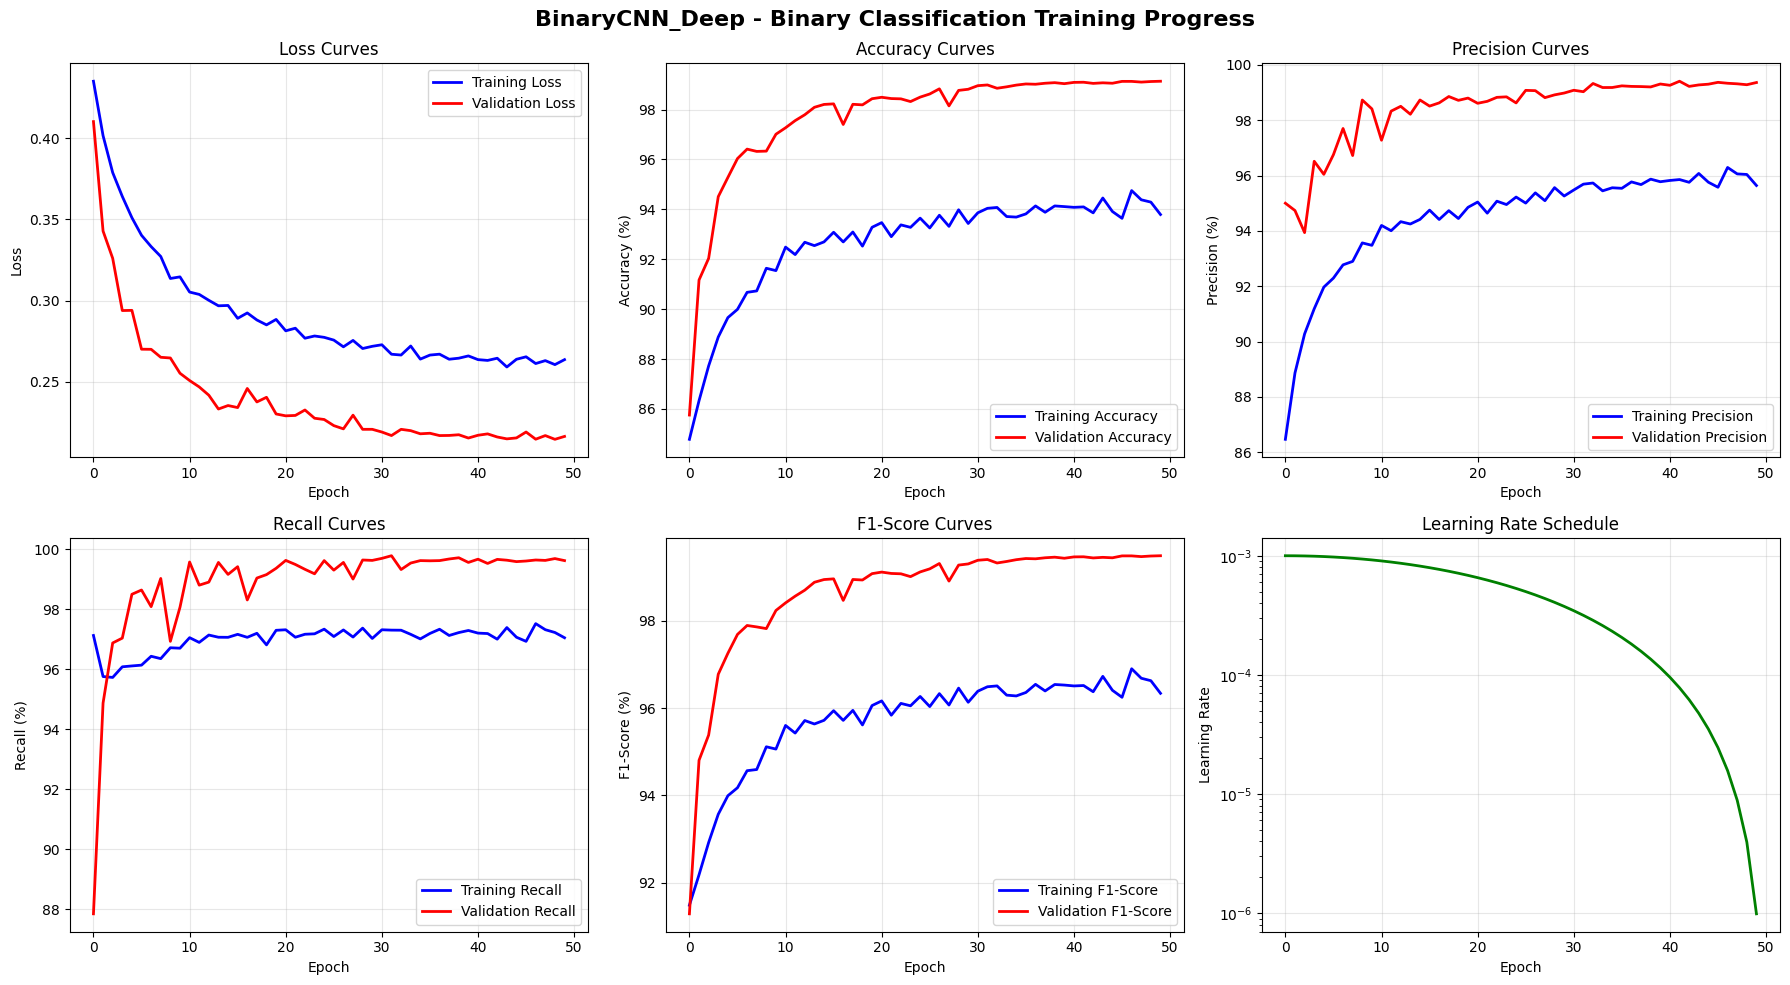

Calculating confusion matrix: 100%|█| 545/545 [00:20<00


✅ Confusion matrix saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Deep_confusion_matrix.png


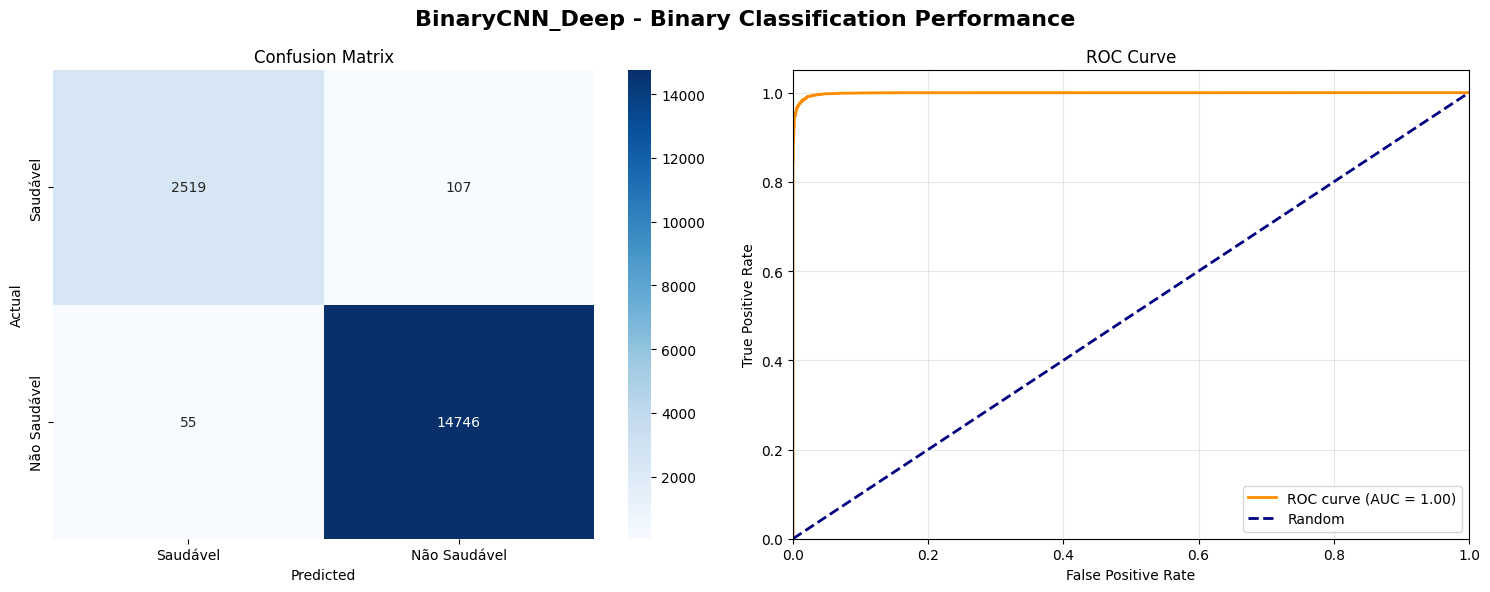


BinaryCNN_Deep - Classification Report
              precision    recall  f1-score   support

    Saudável       0.98      0.96      0.97      2626
Não Saudável       0.99      1.00      0.99     14801

    accuracy                           0.99     17427
   macro avg       0.99      0.98      0.98     17427
weighted avg       0.99      0.99      0.99     17427

ROC-AUC Score: 0.9990


🔧 Training: BinaryCNN_Efficient

📊 Model Configuration:
  Total parameters: 183,266
  Epochs: 50
  Learning rate: 0.001
  Batch size: 32
  Scheduler: cosine
  Mixed precision: True

🚀 Starting training...



Epoch 1/50 [Train]: 100%|█| 1271/1271 [00:51<00:00, 24.
Epoch 1/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 25.96



────────────────────────────────────────────────────────────────────────────────
Epoch 1/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3868 | Val Loss: 0.3357
Train Acc: 87.33% | Val Acc: 91.86%
Train Prec: 89.73% | Val Prec: 97.45%
Train Recall: 95.92% | Val Recall: 92.85%
Train F1: 92.72% | Val F1: 95.09%
Learning Rate: 0.001000
────────────────────────────────────────────────────────────────────────────────



Epoch 2/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25.
Epoch 2/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.02



────────────────────────────────────────────────────────────────────────────────
Epoch 2/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3512 | Val Loss: 0.2940
Train Acc: 89.45% | Val Acc: 94.45%
Train Prec: 91.86% | Val Prec: 94.66%
Train Recall: 95.97% | Val Recall: 99.05%
Train F1: 93.87% | Val F1: 96.81%
Learning Rate: 0.000999
────────────────────────────────────────────────────────────────────────────────



Epoch 3/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25.
Epoch 3/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.45



────────────────────────────────────────────────────────────────────────────────
Epoch 3/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3324 | Val Loss: 0.2742
Train Acc: 90.38% | Val Acc: 96.22%
Train Prec: 92.67% | Val Prec: 96.91%
Train Recall: 96.18% | Val Recall: 98.69%
Train F1: 94.39% | Val F1: 97.79%
Learning Rate: 0.000996
────────────────────────────────────────────────────────────────────────────────



Epoch 4/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25.
Epoch 4/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.25



────────────────────────────────────────────────────────────────────────────────
Epoch 4/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3207 | Val Loss: 0.2728
Train Acc: 91.51% | Val Acc: 96.67%
Train Prec: 93.61% | Val Prec: 98.36%
Train Recall: 96.50% | Val Recall: 97.70%
Train F1: 95.03% | Val F1: 98.03%
Learning Rate: 0.000991
────────────────────────────────────────────────────────────────────────────────



Epoch 5/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25.
Epoch 5/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.03



────────────────────────────────────────────────────────────────────────────────
Epoch 5/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3138 | Val Loss: 0.2640
Train Acc: 91.87% | Val Acc: 97.26%
Train Prec: 93.91% | Val Prec: 97.69%
Train Recall: 96.61% | Val Recall: 99.11%
Train F1: 95.24% | Val F1: 98.40%
Learning Rate: 0.000984
────────────────────────────────────────────────────────────────────────────────



Epoch 6/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25.
Epoch 6/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.12



────────────────────────────────────────────────────────────────────────────────
Epoch 6/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3077 | Val Loss: 0.2530
Train Acc: 92.03% | Val Acc: 97.74%
Train Prec: 94.09% | Val Prec: 98.28%
Train Recall: 96.60% | Val Recall: 99.07%
Train F1: 95.33% | Val F1: 98.68%
Learning Rate: 0.000976
────────────────────────────────────────────────────────────────────────────────



Epoch 7/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25.
Epoch 7/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 25.99



────────────────────────────────────────────────────────────────────────────────
Epoch 7/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.3050 | Val Loss: 0.2491
Train Acc: 92.43% | Val Acc: 98.03%
Train Prec: 94.38% | Val Prec: 98.21%
Train Recall: 96.76% | Val Recall: 99.49%
Train F1: 95.56% | Val F1: 98.85%
Learning Rate: 0.000965
────────────────────────────────────────────────────────────────────────────────



Epoch 8/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26.
Epoch 8/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.45



────────────────────────────────────────────────────────────────────────────────
Epoch 8/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2995 | Val Loss: 0.2504
Train Acc: 93.01% | Val Acc: 97.69%
Train Prec: 94.73% | Val Prec: 98.66%
Train Recall: 97.10% | Val Recall: 98.61%
Train F1: 95.90% | Val F1: 98.64%
Learning Rate: 0.000952
────────────────────────────────────────────────────────────────────────────────



Epoch 9/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25.
Epoch 9/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.20



────────────────────────────────────────────────────────────────────────────────
Epoch 9/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2993 | Val Loss: 0.2540
Train Acc: 92.93% | Val Acc: 97.95%
Train Prec: 94.68% | Val Prec: 98.84%
Train Recall: 97.05% | Val Recall: 98.74%
Train F1: 95.85% | Val F1: 98.79%
Learning Rate: 0.000938
────────────────────────────────────────────────────────────────────────────────



Epoch 10/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 10/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.0



────────────────────────────────────────────────────────────────────────────────
Epoch 10/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2942 | Val Loss: 0.2467
Train Acc: 93.00% | Val Acc: 98.11%
Train Prec: 94.89% | Val Prec: 98.24%
Train Recall: 96.89% | Val Recall: 99.56%
Train F1: 95.88% | Val F1: 98.90%
Learning Rate: 0.000922
────────────────────────────────────────────────────────────────────────────────



Epoch 11/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 11/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 11/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2930 | Val Loss: 0.2460
Train Acc: 93.24% | Val Acc: 97.97%
Train Prec: 94.89% | Val Prec: 98.85%
Train Recall: 97.21% | Val Recall: 98.76%
Train F1: 96.03% | Val F1: 98.81%
Learning Rate: 0.000905
────────────────────────────────────────────────────────────────────────────────



Epoch 12/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 12/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 12/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2878 | Val Loss: 0.2432
Train Acc: 93.28% | Val Acc: 98.31%
Train Prec: 95.11% | Val Prec: 98.53%
Train Recall: 97.00% | Val Recall: 99.50%
Train F1: 96.05% | Val F1: 99.01%
Learning Rate: 0.000885
────────────────────────────────────────────────────────────────────────────────



Epoch 13/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 13/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 13/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2899 | Val Loss: 0.2373
Train Acc: 93.42% | Val Acc: 98.60%
Train Prec: 95.07% | Val Prec: 98.74%
Train Recall: 97.23% | Val Recall: 99.62%
Train F1: 96.14% | Val F1: 99.18%
Learning Rate: 0.000864
────────────────────────────────────────────────────────────────────────────────



Epoch 14/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 14/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 14/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2835 | Val Loss: 0.2386
Train Acc: 93.64% | Val Acc: 98.60%
Train Prec: 95.31% | Val Prec: 99.03%
Train Recall: 97.22% | Val Recall: 99.32%
Train F1: 96.26% | Val F1: 99.18%
Learning Rate: 0.000842
────────────────────────────────────────────────────────────────────────────────



Epoch 15/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 15/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.4



────────────────────────────────────────────────────────────────────────────────
Epoch 15/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2869 | Val Loss: 0.2362
Train Acc: 93.74% | Val Acc: 98.57%
Train Prec: 95.29% | Val Prec: 98.80%
Train Recall: 97.38% | Val Recall: 99.53%
Train F1: 96.32% | Val F1: 99.16%
Learning Rate: 0.000819
────────────────────────────────────────────────────────────────────────────────



Epoch 16/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 16/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 16/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2837 | Val Loss: 0.2363
Train Acc: 93.26% | Val Acc: 98.53%
Train Prec: 95.03% | Val Prec: 98.90%
Train Recall: 97.07% | Val Recall: 99.37%
Train F1: 96.04% | Val F1: 99.13%
Learning Rate: 0.000794
────────────────────────────────────────────────────────────────────────────────



Epoch 17/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 17/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 17/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2840 | Val Loss: 0.2358
Train Acc: 93.55% | Val Acc: 98.50%
Train Prec: 95.20% | Val Prec: 98.67%
Train Recall: 97.24% | Val Recall: 99.57%
Train F1: 96.21% | Val F1: 99.12%
Learning Rate: 0.000768
────────────────────────────────────────────────────────────────────────────────



Epoch 18/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 18/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.0



────────────────────────────────────────────────────────────────────────────────
Epoch 18/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2849 | Val Loss: 0.2414
Train Acc: 93.26% | Val Acc: 98.35%
Train Prec: 95.01% | Val Prec: 98.61%
Train Recall: 97.10% | Val Recall: 99.45%
Train F1: 96.04% | Val F1: 99.03%
Learning Rate: 0.000741
────────────────────────────────────────────────────────────────────────────────



Epoch 19/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 19/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 19/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2819 | Val Loss: 0.2328
Train Acc: 93.13% | Val Acc: 98.63%
Train Prec: 95.01% | Val Prec: 98.91%
Train Recall: 96.92% | Val Recall: 99.49%
Train F1: 95.96% | Val F1: 99.20%
Learning Rate: 0.000713
────────────────────────────────────────────────────────────────────────────────



Epoch 20/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 20/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 20/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2764 | Val Loss: 0.2332
Train Acc: 93.86% | Val Acc: 98.67%
Train Prec: 95.52% | Val Prec: 98.85%
Train Recall: 97.27% | Val Recall: 99.59%
Train F1: 96.39% | Val F1: 99.22%
Learning Rate: 0.000684
────────────────────────────────────────────────────────────────────────────────



Epoch 21/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 21/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.0



────────────────────────────────────────────────────────────────────────────────
Epoch 21/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2784 | Val Loss: 0.2354
Train Acc: 93.82% | Val Acc: 98.62%
Train Prec: 95.48% | Val Prec: 99.15%
Train Recall: 97.25% | Val Recall: 99.23%
Train F1: 96.36% | Val F1: 99.19%
Learning Rate: 0.000655
────────────────────────────────────────────────────────────────────────────────



Epoch 22/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 22/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 22/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2772 | Val Loss: 0.2310
Train Acc: 93.88% | Val Acc: 98.80%
Train Prec: 95.52% | Val Prec: 98.92%
Train Recall: 97.29% | Val Recall: 99.68%
Train F1: 96.40% | Val F1: 99.30%
Learning Rate: 0.000624
────────────────────────────────────────────────────────────────────────────────



Epoch 23/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 23/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 23/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2751 | Val Loss: 0.2295
Train Acc: 94.00% | Val Acc: 98.81%
Train Prec: 95.62% | Val Prec: 98.97%
Train Recall: 97.33% | Val Recall: 99.64%
Train F1: 96.47% | Val F1: 99.30%
Learning Rate: 0.000594
────────────────────────────────────────────────────────────────────────────────



Epoch 24/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 24/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 24/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2761 | Val Loss: 0.2304
Train Acc: 93.50% | Val Acc: 98.65%
Train Prec: 95.33% | Val Prec: 98.79%
Train Recall: 97.03% | Val Recall: 99.63%
Train F1: 96.17% | Val F1: 99.21%
Learning Rate: 0.000563
────────────────────────────────────────────────────────────────────────────────



Epoch 25/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 25/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 25/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2748 | Val Loss: 0.2282
Train Acc: 93.77% | Val Acc: 98.79%
Train Prec: 95.54% | Val Prec: 98.97%
Train Recall: 97.13% | Val Recall: 99.61%
Train F1: 96.33% | Val F1: 99.29%
Learning Rate: 0.000531
────────────────────────────────────────────────────────────────────────────────



Epoch 26/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 26/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 26/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2742 | Val Loss: 0.2280
Train Acc: 93.88% | Val Acc: 98.88%
Train Prec: 95.59% | Val Prec: 99.03%
Train Recall: 97.22% | Val Recall: 99.66%
Train F1: 96.40% | Val F1: 99.34%
Learning Rate: 0.000500
────────────────────────────────────────────────────────────────────────────────



Epoch 27/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 27/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 27/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2706 | Val Loss: 0.2291
Train Acc: 94.11% | Val Acc: 98.74%
Train Prec: 95.73% | Val Prec: 98.80%
Train Recall: 97.33% | Val Recall: 99.73%
Train F1: 96.53% | Val F1: 99.26%
Learning Rate: 0.000469
────────────────────────────────────────────────────────────────────────────────



Epoch 28/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 28/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 28/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2729 | Val Loss: 0.2282
Train Acc: 94.36% | Val Acc: 98.84%
Train Prec: 95.92% | Val Prec: 98.88%
Train Recall: 97.45% | Val Recall: 99.76%
Train F1: 96.68% | Val F1: 99.32%
Learning Rate: 0.000437
────────────────────────────────────────────────────────────────────────────────



Epoch 29/50 [Train]: 100%|█| 1271/1271 [00:50<00:00, 25
Epoch 29/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 29/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2721 | Val Loss: 0.2262
Train Acc: 94.26% | Val Acc: 98.90%
Train Prec: 95.81% | Val Prec: 98.90%
Train Recall: 97.45% | Val Recall: 99.82%
Train F1: 96.62% | Val F1: 99.36%
Learning Rate: 0.000406
────────────────────────────────────────────────────────────────────────────────



Epoch 30/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 30/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 30/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2737 | Val Loss: 0.2275
Train Acc: 93.43% | Val Acc: 98.93%
Train Prec: 95.31% | Val Prec: 99.18%
Train Recall: 96.97% | Val Recall: 99.56%
Train F1: 96.13% | Val F1: 99.37%
Learning Rate: 0.000376
────────────────────────────────────────────────────────────────────────────────



Epoch 31/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 31/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 31/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2715 | Val Loss: 0.2276
Train Acc: 94.10% | Val Acc: 98.80%
Train Prec: 95.74% | Val Prec: 98.84%
Train Recall: 97.32% | Val Recall: 99.76%
Train F1: 96.52% | Val F1: 99.30%
Learning Rate: 0.000345
────────────────────────────────────────────────────────────────────────────────



Epoch 32/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 32/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 32/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2719 | Val Loss: 0.2260
Train Acc: 93.33% | Val Acc: 98.94%
Train Prec: 95.30% | Val Prec: 99.21%
Train Recall: 96.84% | Val Recall: 99.54%
Train F1: 96.07% | Val F1: 99.38%
Learning Rate: 0.000316
────────────────────────────────────────────────────────────────────────────────



Epoch 33/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 33/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 33/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2690 | Val Loss: 0.2261
Train Acc: 94.11% | Val Acc: 98.98%
Train Prec: 95.79% | Val Prec: 99.07%
Train Recall: 97.28% | Val Recall: 99.74%
Train F1: 96.53% | Val F1: 99.40%
Learning Rate: 0.000287
────────────────────────────────────────────────────────────────────────────────



Epoch 34/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 34/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 34/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2711 | Val Loss: 0.2254
Train Acc: 93.82% | Val Acc: 98.90%
Train Prec: 95.61% | Val Prec: 99.15%
Train Recall: 97.12% | Val Recall: 99.57%
Train F1: 96.36% | Val F1: 99.36%
Learning Rate: 0.000259
────────────────────────────────────────────────────────────────────────────────



Epoch 35/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 35/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 35/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2691 | Val Loss: 0.2255
Train Acc: 93.46% | Val Acc: 98.93%
Train Prec: 95.38% | Val Prec: 99.11%
Train Recall: 96.92% | Val Recall: 99.64%
Train F1: 96.14% | Val F1: 99.37%
Learning Rate: 0.000232
────────────────────────────────────────────────────────────────────────────────



Epoch 36/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 36/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 36/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2751 | Val Loss: 0.2262
Train Acc: 93.46% | Val Acc: 98.97%
Train Prec: 95.35% | Val Prec: 99.17%
Train Recall: 96.96% | Val Recall: 99.62%
Train F1: 96.15% | Val F1: 99.40%
Learning Rate: 0.000206
────────────────────────────────────────────────────────────────────────────────



Epoch 37/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 37/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 37/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2705 | Val Loss: 0.2243
Train Acc: 93.76% | Val Acc: 98.98%
Train Prec: 95.56% | Val Prec: 99.18%
Train Recall: 97.10% | Val Recall: 99.63%
Train F1: 96.32% | Val F1: 99.40%
Learning Rate: 0.000181
────────────────────────────────────────────────────────────────────────────────



Epoch 38/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 38/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 38/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2694 | Val Loss: 0.2244
Train Acc: 94.13% | Val Acc: 99.02%
Train Prec: 95.80% | Val Prec: 99.23%
Train Recall: 97.29% | Val Recall: 99.63%
Train F1: 96.54% | Val F1: 99.43%
Learning Rate: 0.000158
────────────────────────────────────────────────────────────────────────────────



Epoch 39/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 39/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 39/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2686 | Val Loss: 0.2246
Train Acc: 93.66% | Val Acc: 99.08%
Train Prec: 95.55% | Val Prec: 99.27%
Train Recall: 96.98% | Val Recall: 99.64%
Train F1: 96.26% | Val F1: 99.46%
Learning Rate: 0.000136
────────────────────────────────────────────────────────────────────────────────



Epoch 40/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 40/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 40/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2655 | Val Loss: 0.2260
Train Acc: 94.33% | Val Acc: 98.99%
Train Prec: 95.95% | Val Prec: 99.32%
Train Recall: 97.37% | Val Recall: 99.49%
Train F1: 96.66% | Val F1: 99.41%
Learning Rate: 0.000115
────────────────────────────────────────────────────────────────────────────────



Epoch 41/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 26
Epoch 41/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.5



────────────────────────────────────────────────────────────────────────────────
Epoch 41/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2706 | Val Loss: 0.2248
Train Acc: 93.65% | Val Acc: 99.04%
Train Prec: 95.56% | Val Prec: 99.19%
Train Recall: 96.96% | Val Recall: 99.68%
Train F1: 96.25% | Val F1: 99.44%
Learning Rate: 0.000095
────────────────────────────────────────────────────────────────────────────────



Epoch 42/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 42/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 42/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2686 | Val Loss: 0.2237
Train Acc: 94.18% | Val Acc: 99.00%
Train Prec: 95.88% | Val Prec: 99.12%
Train Recall: 97.27% | Val Recall: 99.71%
Train F1: 96.57% | Val F1: 99.41%
Learning Rate: 0.000078
────────────────────────────────────────────────────────────────────────────────



Epoch 43/50 [Train]: 100%|█| 1271/1271 [00:48<00:00, 25
Epoch 43/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 43/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2684 | Val Loss: 0.2229
Train Acc: 93.94% | Val Acc: 99.08%
Train Prec: 95.69% | Val Prec: 99.25%
Train Recall: 97.17% | Val Recall: 99.67%
Train F1: 96.43% | Val F1: 99.46%
Learning Rate: 0.000062
────────────────────────────────────────────────────────────────────────────────



Epoch 44/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 44/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.0



────────────────────────────────────────────────────────────────────────────────
Epoch 44/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2681 | Val Loss: 0.2234
Train Acc: 93.97% | Val Acc: 98.96%
Train Prec: 95.70% | Val Prec: 99.08%
Train Recall: 97.20% | Val Recall: 99.70%
Train F1: 96.44% | Val F1: 99.39%
Learning Rate: 0.000048
────────────────────────────────────────────────────────────────────────────────



Epoch 45/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 45/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 25.9



────────────────────────────────────────────────────────────────────────────────
Epoch 45/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2655 | Val Loss: 0.2238
Train Acc: 93.69% | Val Acc: 99.05%
Train Prec: 95.57% | Val Prec: 99.25%
Train Recall: 96.99% | Val Recall: 99.64%
Train F1: 96.28% | Val F1: 99.44%
Learning Rate: 0.000035
────────────────────────────────────────────────────────────────────────────────



Epoch 46/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 46/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 46/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2626 | Val Loss: 0.2232
Train Acc: 94.12% | Val Acc: 99.02%
Train Prec: 95.93% | Val Prec: 99.20%
Train Recall: 97.13% | Val Recall: 99.65%
Train F1: 96.53% | Val F1: 99.42%
Learning Rate: 0.000024
────────────────────────────────────────────────────────────────────────────────



Epoch 47/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 47/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 47/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2665 | Val Loss: 0.2233
Train Acc: 94.28% | Val Acc: 99.00%
Train Prec: 95.87% | Val Prec: 99.15%
Train Recall: 97.40% | Val Recall: 99.68%
Train F1: 96.63% | Val F1: 99.41%
Learning Rate: 0.000016
────────────────────────────────────────────────────────────────────────────────



Epoch 48/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 48/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.3



────────────────────────────────────────────────────────────────────────────────
Epoch 48/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2703 | Val Loss: 0.2229
Train Acc: 94.00% | Val Acc: 99.13%
Train Prec: 95.70% | Val Prec: 99.28%
Train Recall: 97.24% | Val Recall: 99.70%
Train F1: 96.47% | Val F1: 99.49%
Learning Rate: 0.000009
────────────────────────────────────────────────────────────────────────────────



Epoch 49/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 49/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.1



────────────────────────────────────────────────────────────────────────────────
Epoch 49/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2659 | Val Loss: 0.2231
Train Acc: 93.97% | Val Acc: 99.01%
Train Prec: 95.76% | Val Prec: 99.18%
Train Recall: 97.14% | Val Recall: 99.66%
Train F1: 96.44% | Val F1: 99.42%
Learning Rate: 0.000004
────────────────────────────────────────────────────────────────────────────────



Epoch 50/50 [Train]: 100%|█| 1271/1271 [00:49<00:00, 25
Epoch 50/50 [Val]  : 100%|█| 545/545 [00:20<00:00, 26.2



────────────────────────────────────────────────────────────────────────────────
Epoch 50/50 Summary:
────────────────────────────────────────────────────────────────────────────────
Train Loss: 0.2678 | Val Loss: 0.2226
Train Acc: 94.17% | Val Acc: 99.09%
Train Prec: 95.85% | Val Prec: 99.25%
Train Recall: 97.29% | Val Recall: 99.68%
Train F1: 96.56% | Val F1: 99.47%
Learning Rate: 0.000001
────────────────────────────────────────────────────────────────────────────────


✅ Training Completed!
Total training time: 58.69 minutes
Best validation accuracy: 99.13% at epoch 48

💾 Model saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Efficient_best.pth

✅ Training curves saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Efficient_training_curves.png


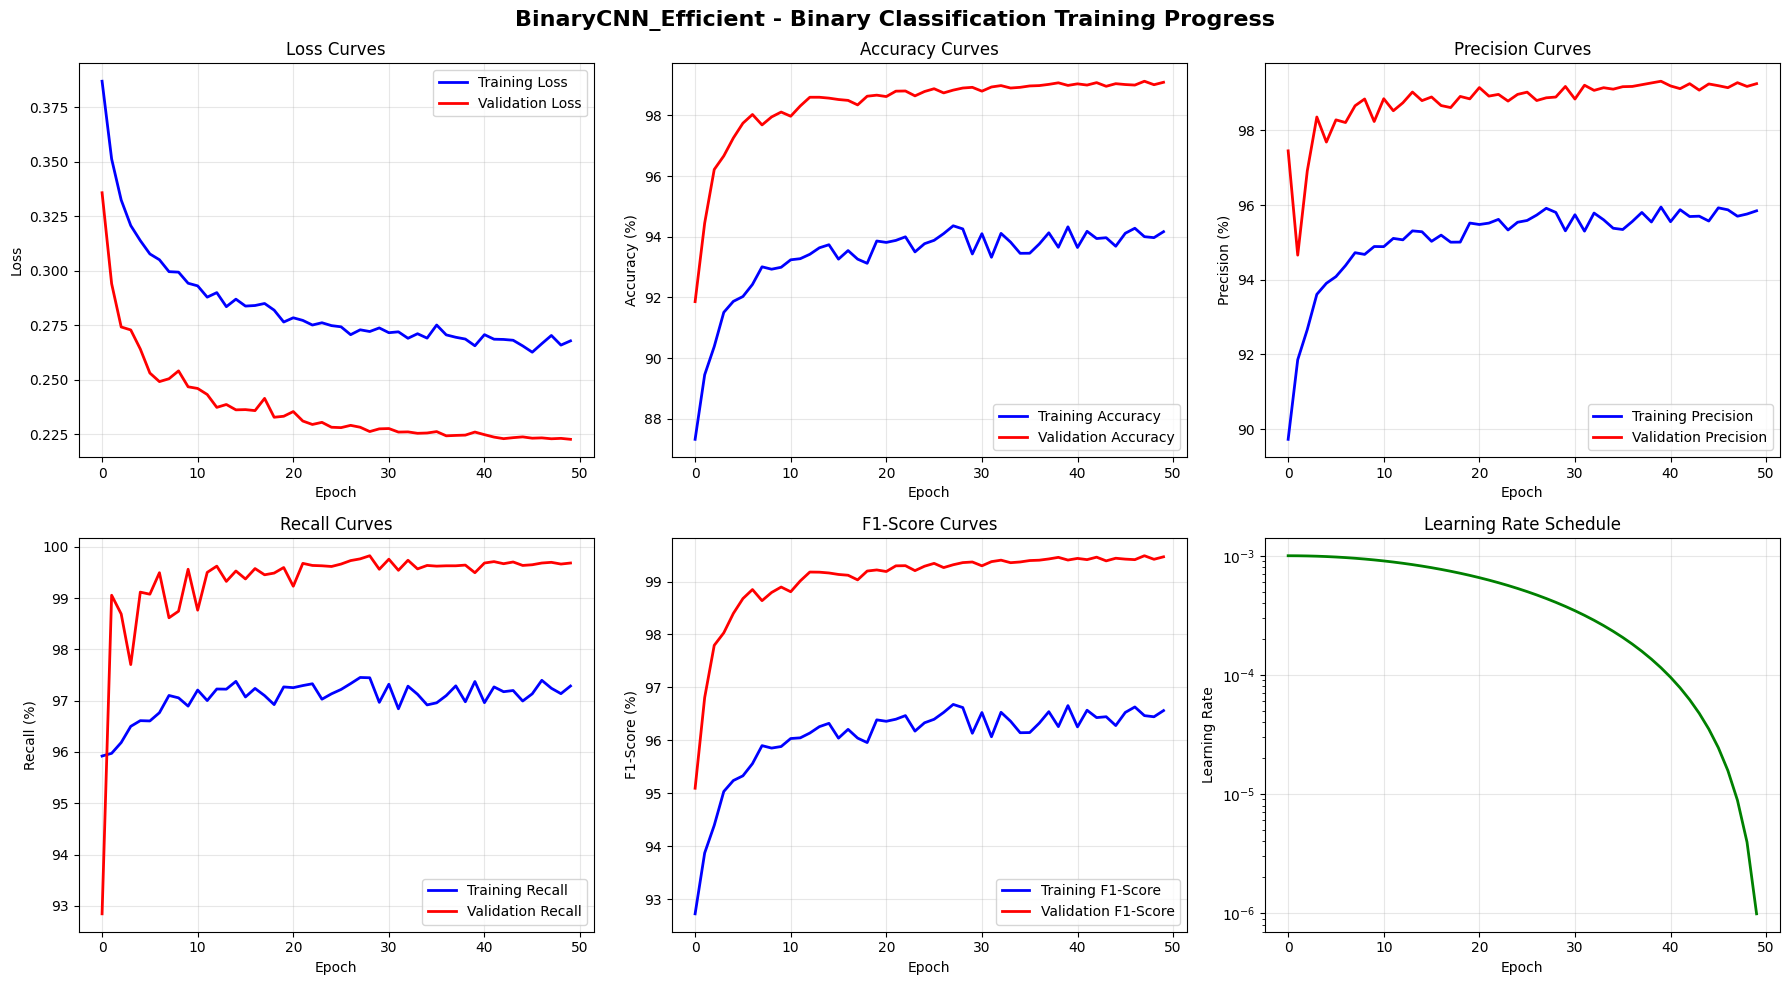

Calculating confusion matrix: 100%|█| 545/545 [00:20<00


✅ Confusion matrix saved to ./modulo_final/sprint_2/modelos/BinaryCNN_Efficient_confusion_matrix.png


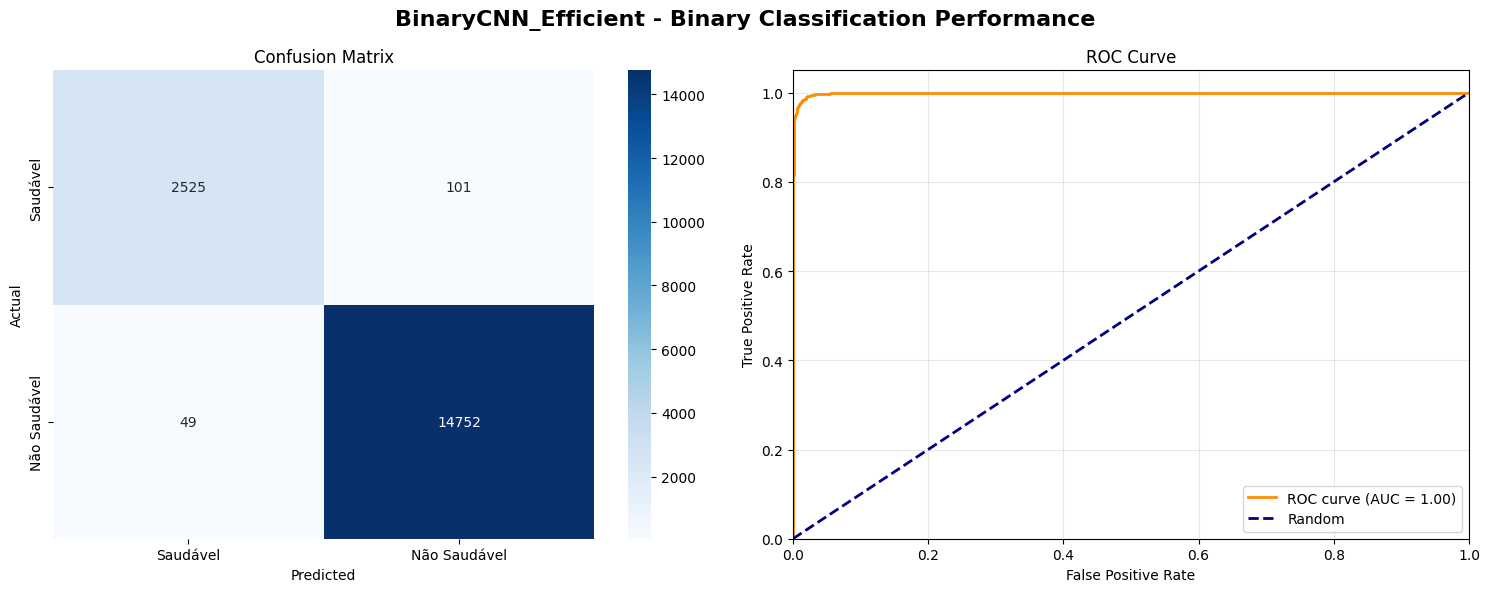


BinaryCNN_Efficient - Classification Report
              precision    recall  f1-score   support

    Saudável       0.98      0.96      0.97      2626
Não Saudável       0.99      1.00      0.99     14801

    accuracy                           0.99     17427
   macro avg       0.99      0.98      0.98     17427
weighted avg       0.99      0.99      0.99     17427

ROC-AUC Score: 0.9987


🎉 Training Pipeline Completed!
Trained models: ['BinaryCNN_Light', 'BinaryCNN_Deep', 'BinaryCNN_Efficient']
Results saved to: ./modulo_final/sprint_2/modelos

✅ Model comparison saved to ./modulo_final/sprint_2/modelos/model_comparison.png


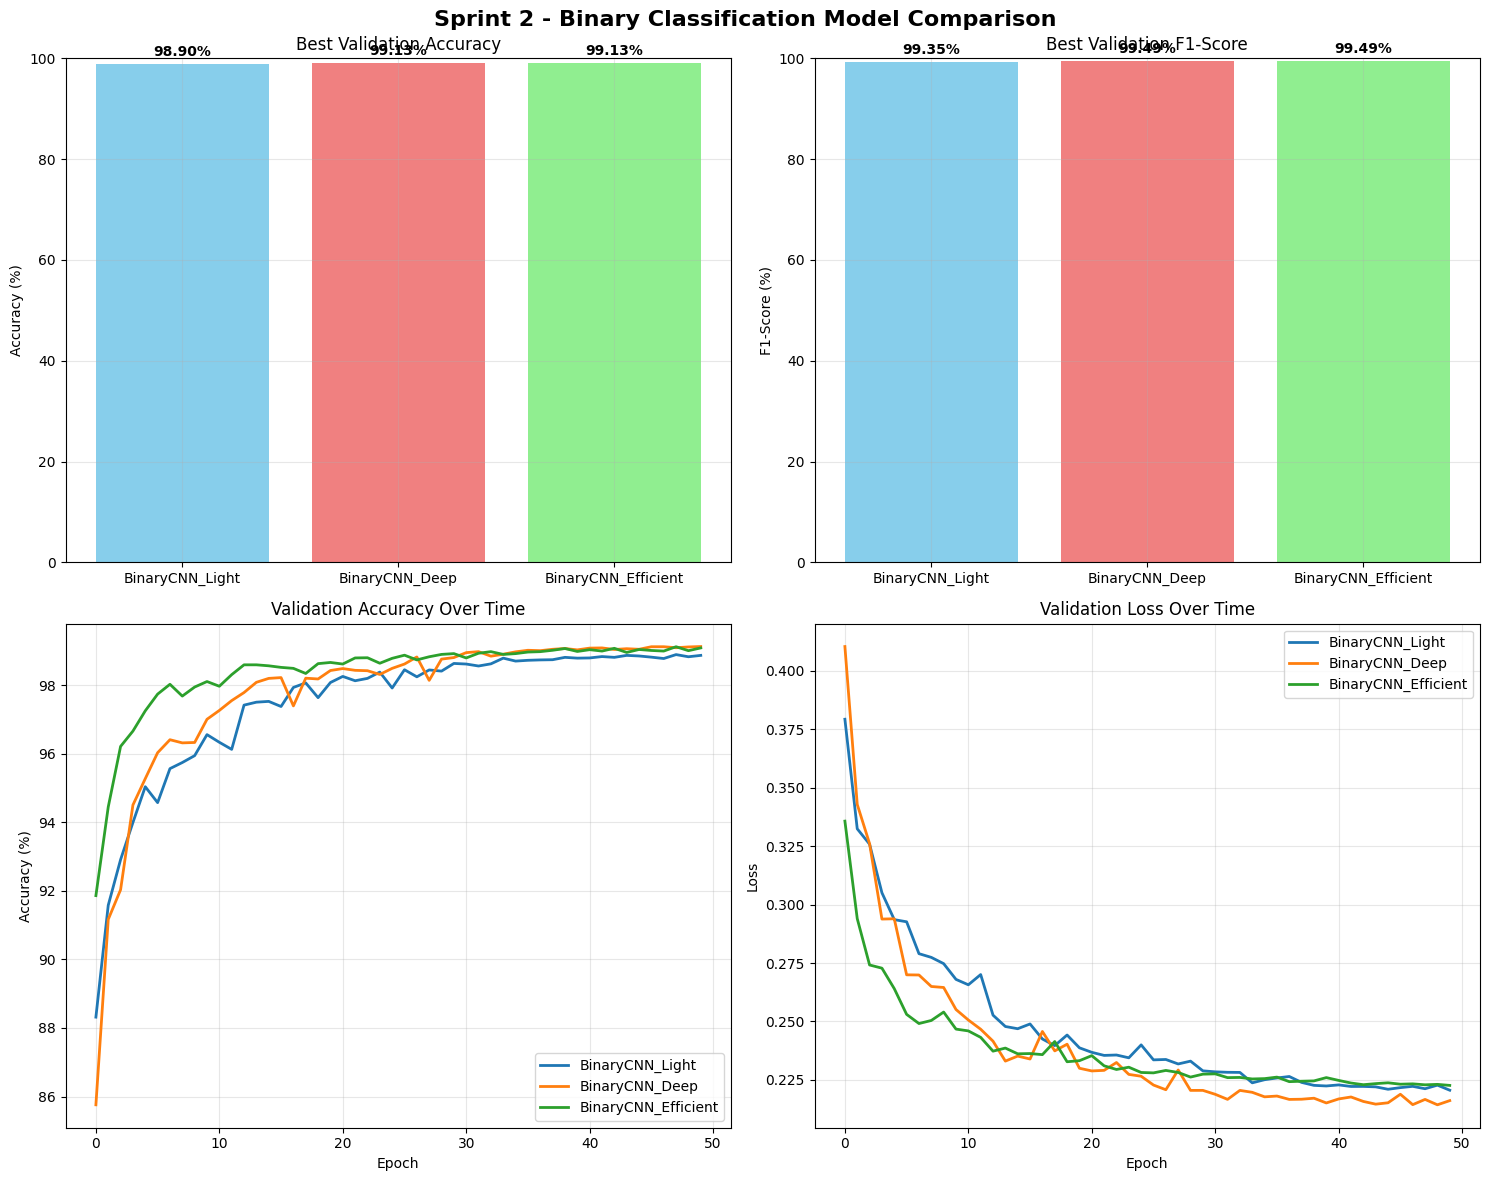


📊 Final Results Summary

BinaryCNN_Light:
  Best Accuracy: 98.90% at epoch 48
  Best F1-Score: 99.35% at epoch 48

BinaryCNN_Deep:
  Best Accuracy: 99.13% at epoch 50
  Best F1-Score: 99.49% at epoch 50

BinaryCNN_Efficient:
  Best Accuracy: 99.13% at epoch 48
  Best F1-Score: 99.49% at epoch 48



In [10]:
# Main Training Pipeline
print("\n" + "="*80)
print("🚀 Starting Sprint 2 Binary Classification Training Pipeline")
print("="*80 + "\n")

# Define binary models
models_dict = {
    "BinaryCNN_Light": BinaryCNN_Light(),
    "BinaryCNN_Deep": BinaryCNN_Deep(),
    "BinaryCNN_Efficient": BinaryCNN_Efficient(),
}

# Print model information
print("📊 Model Information:")
print("─"*80)
for name, model in models_dict.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name}:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
print("─"*80 + "\n")

# Train all models
results = {}
all_metrics = {}

for name, model in models_dict.items():
    try:
        # Train model
        trained_model, metrics = train_and_evaluate_model(
            model, name, train_loader, val_loader, CONFIG
        )
        
        # Store results
        results[name] = trained_model
        all_metrics[name] = metrics
        
        # Save model
        model_path = os.path.join(CONFIG['save_dir'], f'{name}_best.pth')
        torch.save(trained_model.state_dict(), model_path)
        print(f"💾 Model saved to {model_path}\n")
        
        # Plot training curves
        plot_training_curves(metrics, name, 
                           os.path.join(CONFIG['save_dir'], f'{name}_training_curves.png'))
        
        # Plot confusion matrix
        plot_confusion_matrix(trained_model, val_loader, CONFIG['class_names'], name,
                            os.path.join(CONFIG['save_dir'], f'{name}_confusion_matrix.png'))
        
    except Exception as e:
        print(f"❌ Error training {name}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("🎉 Training Pipeline Completed!")
print("="*80)
print(f"Trained models: {list(results.keys())}")
print(f"Results saved to: {CONFIG['save_dir']}")
print("="*80 + "\n")

# Plot model comparison
if all_metrics:
    plot_model_comparison(all_metrics, 
                        os.path.join(CONFIG['save_dir'], 'model_comparison.png'))

# Final results summary
print("\n" + "="*80)
print("📊 Final Results Summary")
print("="*80)
for name, metrics in all_metrics.items():
    best_epoch, best_acc = metrics.get_best_epoch()
    best_f1_idx = np.argmax(metrics.val_f1s)
    best_f1 = metrics.val_f1s[best_f1_idx]
    print(f"\n{name}:")
    print(f"  Best Accuracy: {best_acc:.2f}% at epoch {best_epoch+1}")
    print(f"  Best F1-Score: {best_f1:.2f}% at epoch {best_f1_idx+1}")
print("="*80 + "\n")

## 11. Resumo e Conclusões

### Características da Classificação Binária:

1. **Simplificação do Problema**:
   - Redução de 5 classes para 2 classes (Saudável vs Não Saudável)
   - Aumento esperado na acurácia devido à simplificação
   - Mais adequado para aplicações práticas de detecção de doenças

2. **Métricas Específicas**:
   - **Precision**: Importante para minimizar falsos positivos
   - **Recall**: Importante para minimizar falsos negativos
   - **F1-Score**: Balanço entre Precision e Recall
   - **ROC-AUC**: Capacidade de discriminação do modelo

3. **Arquiteturas Otimizadas**:
   - **BinaryCNN_Light**: Rápido e eficiente para inferência em tempo real
   - **BinaryCNN_Deep**: Maior capacidade com conexões residuais
   - **BinaryCNN_Efficient**: Balanço entre velocidade e acurácia

4. **Técnicas Avançadas**:
   - Data Augmentation (Mixup, CutMix)
   - Learning Rate Scheduling
   - Early Stopping
   - Mixed Precision Training
   - Visualização detalhada de progresso

### Vantagens da Classificação Binária:
- ✅ Maior acurácia esperada
- ✅ Mais simples de interpretar
- ✅ Menos dados necessários para treinamento
- ✅ Ideal para triagem inicial
- ✅ Deploy mais eficiente

### Próximos Passos:
- Análise detalhada das métricas
- Testes com imagens reais
- Otimização de hiperparâmetros
- Preparação para deploy em produção
- Integração com sistema de monitoramento